The Wasserstein GAN (WGAN), introduced in a 2017 paper by Arjovsky et al., was
one of the first big steps toward stabilizing GAN training. With a few changes, the
authors were able to show how to train GANs that have the following two properties
(quoted from the paper):

• A meaningful loss metric that correlates with the generator’s convergence and
sample quality

• Improved stability of the optimization process

First, the Wasserstein loss requires that we use yi = 1 and yi= –1 as labels, rather than
1 and 0. We also remove the sigmoid activation from the final layer of the discrimina‐
tor, so that predictions pi are no longer constrained to fall in the range [0, 1]
but instead can now be any number in the range (−∞, ∞). For this reason, the
discriminator in a WGAN is usually referred to as a critic that outputs a score rather
than a probability.

the WGAN critic tries to maximize the difference between its predic‐
tions for real images and generated images.


the WGAN generator tries to produce images that are scored as
highly as possible by the critic (i.e., the critic is fooled into thinking they are real).

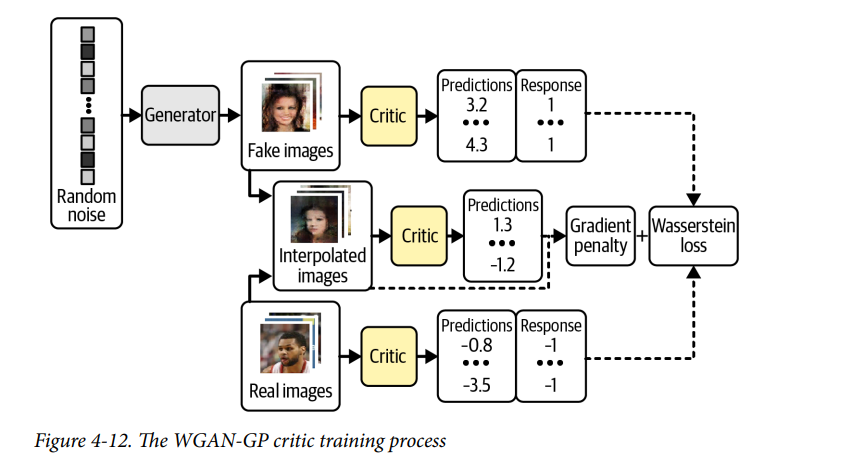

The gradient penalty loss measures the squared difference between the norm of the
gradient of the predictions with respect to the input images and 1. The model will
naturally be inclined to find weights that ensure the gradient penalty term is mini‐
mized, thereby encouraging the model to conform to the Lipschitz constraint.


It is intractable to calculate this gradient everywhere during the training process, so
instead the WGAN-GP evaluates the gradient at only a handful of points. To ensure a
balanced mix, we use a set of interpolated images that lie at randomly chosen points
along lines connecting the batch of real images to the batch of fake images pairwise

# Training the WGAN-GP


A key benefit of using the Wasserstein loss function is that we no longer need to
worry about balancing the training of the critic and the generator—in fact, when
using the Wasserstein loss, the critic must be trained to convergence before updating
the generator, to ensure that the gradients for the generator update are accurate. This
is in contrast to a standard GAN, where it is important not to let the discriminator get
too strong.


Therefore, with Wasserstein GANs, we can simply train the critic several times
between generator updates, to ensure it is close to convergence. A typical ratio used is
three to five critic updates per generator update.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

In [2]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

In [4]:
# Move the uploaded kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Now you can use the Kaggle API to download the dataset
kaggle_username = "jessicali9530"
dataset_name = "celeba-dataset"

# Create the Kaggle dataset URL
dataset_url = f"{kaggle_username}/{dataset_name}"

# Download the dataset using Kaggle API
!kaggle datasets download -d $dataset_url

# Unzip the downloaded dataset
!unzip -q {dataset_name}.zip -d {dataset_name}

100% 1.33G/1.33G [00:34<00:00, 41.9MB/s]
100% 1.33G/1.33G [00:34<00:00, 41.0MB/s]


In [6]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/content/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [7]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

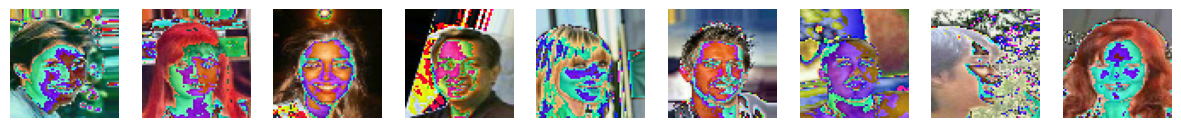

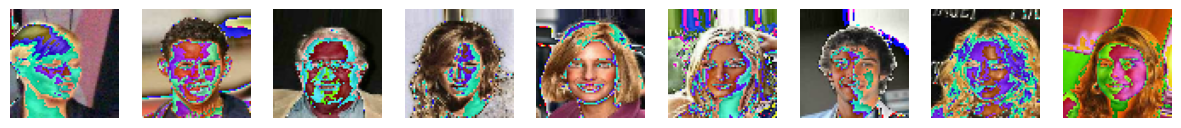

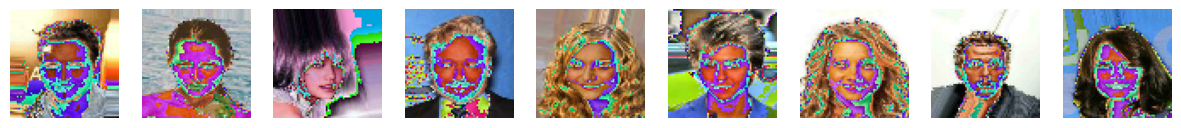

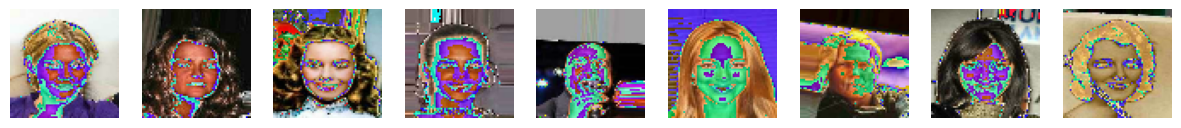

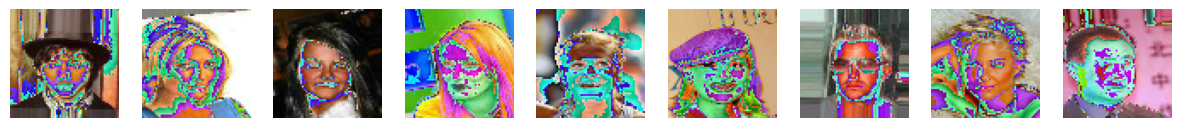

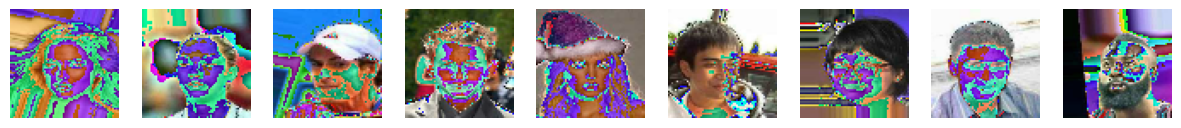

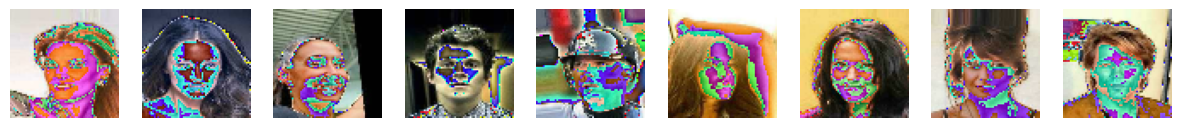

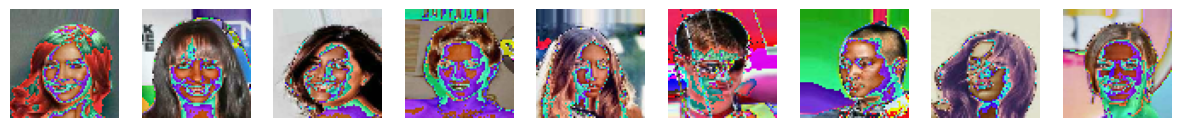

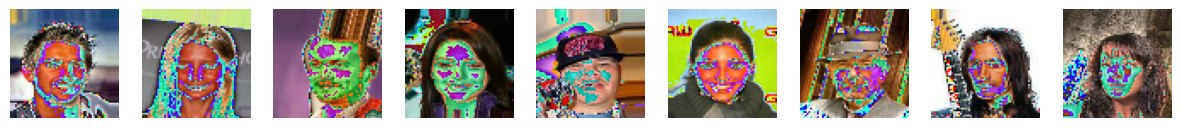

In [8]:
import matplotlib.pyplot as plt
import numpy as np


# Function to display images
def display_images(images, cmap=None):
    plt.figure(figsize=(15, 15))
    for j in range(9):
        celeb_img = images[j].numpy()
        celeb_img = np.array(celeb_img * 255, dtype=np.uint8)  # Convert back to uint8 for display
        plt.subplot(990 + 1 + j)
        plt.imshow(celeb_img, cmap=cmap)
        plt.axis('off')
    plt.show()

# Display random images from the 'train' dataset
for k in range(9):
    train_sample = next(iter(train.take(1)))
    display_images(train_sample, cmap=None)


Batch Normalization in a WGAN-GP


One last consideration we should note before training a WGANGP is that batch normalization shouldn’t be used in the critic. This
is because batch normalization creates correlation between images
in the same batch, which makes the gradient penalty loss less effec‐
tive. Experiments have shown that WGAN-GPs can still produce
excellent results even without batch normalization in the critic.

In [9]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

In [10]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         1048576   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

In [11]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}


In [12]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [13]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [14]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.show()

Epoch 1/200
2/2 [==============================] - ETA: 0s - c_loss: -15.0561 - c_wass_loss: -17.7603 - c_gp: 0.2704 - g_loss: -18.9402

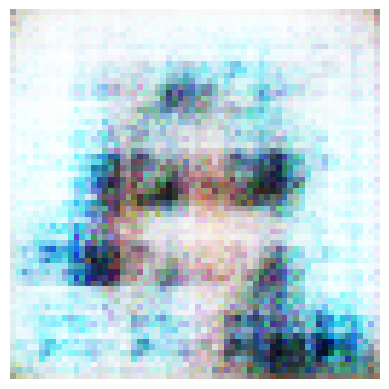

2/2 [==============================] - 7s 3s/step - c_loss: -15.0561 - c_wass_loss: -17.7603 - c_gp: 0.2704 - g_loss: -18.9402
Epoch 2/200
2/2 [==============================] - ETA: 0s - c_loss: -16.0642 - c_wass_loss: -19.4493 - c_gp: 0.3385 - g_loss: -21.3037

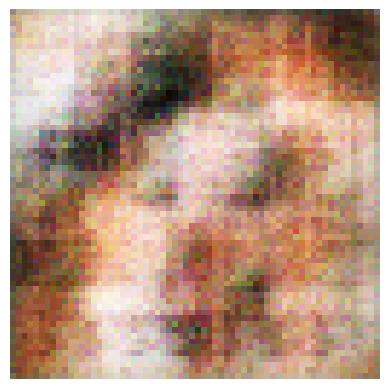

2/2 [==============================] - 5s 3s/step - c_loss: -16.0642 - c_wass_loss: -19.4493 - c_gp: 0.3385 - g_loss: -21.3037
Epoch 3/200
2/2 [==============================] - ETA: 0s - c_loss: -13.5533 - c_wass_loss: -16.3035 - c_gp: 0.2750 - g_loss: -13.7615

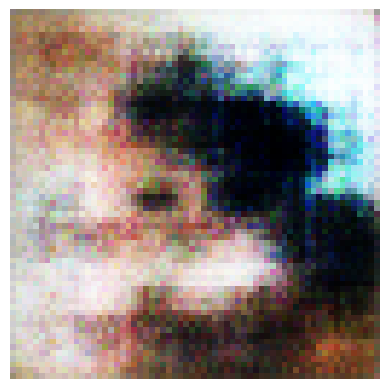

2/2 [==============================] - 5s 3s/step - c_loss: -13.5533 - c_wass_loss: -16.3035 - c_gp: 0.2750 - g_loss: -13.7615
Epoch 4/200
2/2 [==============================] - ETA: 0s - c_loss: -14.6890 - c_wass_loss: -17.3755 - c_gp: 0.2686 - g_loss: -13.3705

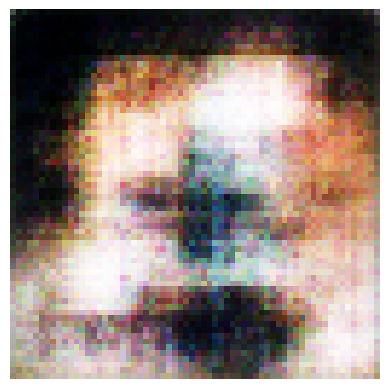

2/2 [==============================] - 5s 3s/step - c_loss: -14.6890 - c_wass_loss: -17.3755 - c_gp: 0.2686 - g_loss: -13.3705
Epoch 5/200
2/2 [==============================] - ETA: 0s - c_loss: -15.4441 - c_wass_loss: -18.6260 - c_gp: 0.3182 - g_loss: -3.2880

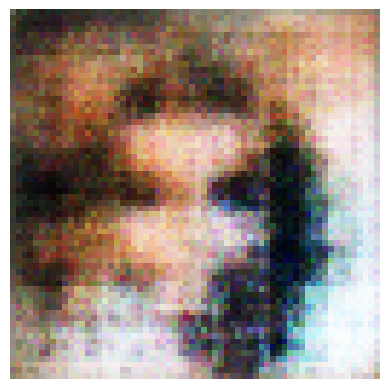

2/2 [==============================] - 5s 3s/step - c_loss: -15.4441 - c_wass_loss: -18.6260 - c_gp: 0.3182 - g_loss: -3.2880
Epoch 6/200
2/2 [==============================] - ETA: 0s - c_loss: -11.3550 - c_wass_loss: -13.1821 - c_gp: 0.1827 - g_loss: -19.9682

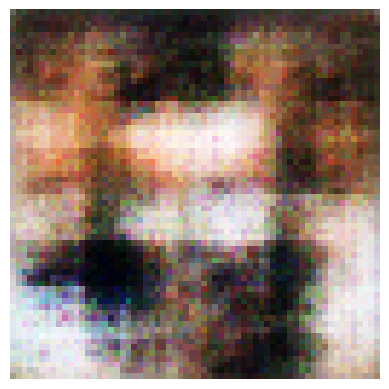

2/2 [==============================] - 5s 3s/step - c_loss: -11.3550 - c_wass_loss: -13.1821 - c_gp: 0.1827 - g_loss: -19.9682
Epoch 7/200
2/2 [==============================] - ETA: 0s - c_loss: -15.7262 - c_wass_loss: -18.2781 - c_gp: 0.2552 - g_loss: -14.1242

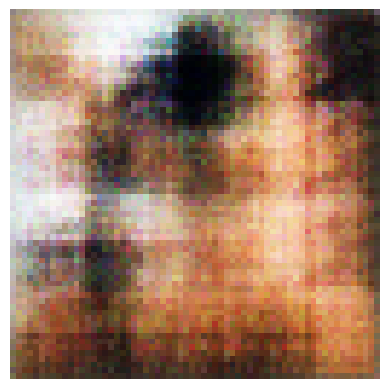

2/2 [==============================] - 5s 3s/step - c_loss: -15.7262 - c_wass_loss: -18.2781 - c_gp: 0.2552 - g_loss: -14.1242
Epoch 8/200
2/2 [==============================] - ETA: 0s - c_loss: -16.5388 - c_wass_loss: -20.2364 - c_gp: 0.3698 - g_loss: -22.1038

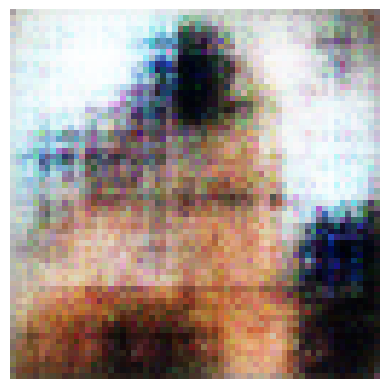

2/2 [==============================] - 5s 3s/step - c_loss: -16.5388 - c_wass_loss: -20.2364 - c_gp: 0.3698 - g_loss: -22.1038
Epoch 9/200
2/2 [==============================] - ETA: 0s - c_loss: -11.5032 - c_wass_loss: -13.4909 - c_gp: 0.1988 - g_loss: -30.9310

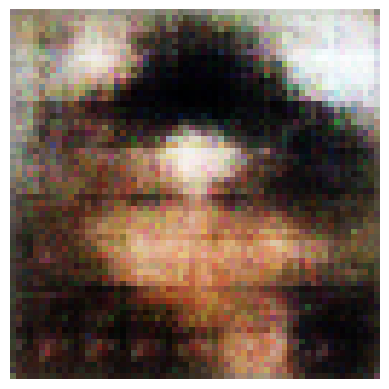

2/2 [==============================] - 5s 3s/step - c_loss: -11.5032 - c_wass_loss: -13.4909 - c_gp: 0.1988 - g_loss: -30.9310
Epoch 10/200
2/2 [==============================] - ETA: 0s - c_loss: -12.8039 - c_wass_loss: -14.3790 - c_gp: 0.1575 - g_loss: -5.0402 

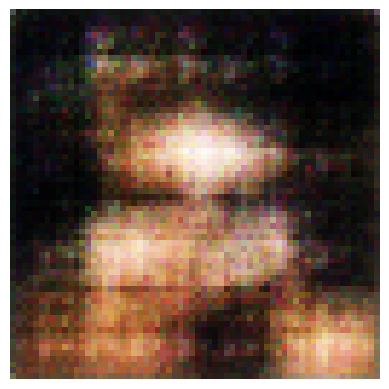

2/2 [==============================] - 5s 3s/step - c_loss: -12.8039 - c_wass_loss: -14.3790 - c_gp: 0.1575 - g_loss: -5.0402
Epoch 11/200
2/2 [==============================] - ETA: 0s - c_loss: -16.6399 - c_wass_loss: -19.9253 - c_gp: 0.3285 - g_loss: 5.8149 

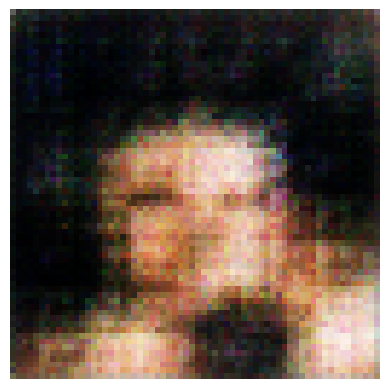

2/2 [==============================] - 5s 3s/step - c_loss: -16.6399 - c_wass_loss: -19.9253 - c_gp: 0.3285 - g_loss: 5.8149
Epoch 12/200
2/2 [==============================] - ETA: 0s - c_loss: -12.3760 - c_wass_loss: -14.9260 - c_gp: 0.2550 - g_loss: -33.3456

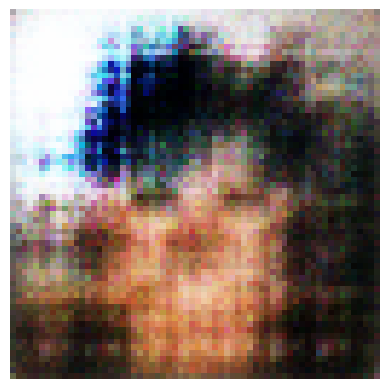

2/2 [==============================] - 5s 3s/step - c_loss: -12.3760 - c_wass_loss: -14.9260 - c_gp: 0.2550 - g_loss: -33.3456
Epoch 13/200
2/2 [==============================] - ETA: 0s - c_loss: -14.6322 - c_wass_loss: -16.9701 - c_gp: 0.2338 - g_loss: -21.8590

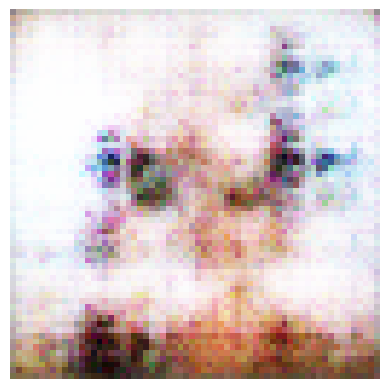

2/2 [==============================] - 5s 3s/step - c_loss: -14.6322 - c_wass_loss: -16.9701 - c_gp: 0.2338 - g_loss: -21.8590
Epoch 14/200
2/2 [==============================] - ETA: 0s - c_loss: -13.5969 - c_wass_loss: -16.4745 - c_gp: 0.2878 - g_loss: -21.1339

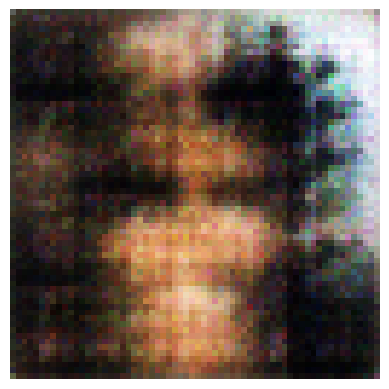

2/2 [==============================] - 5s 3s/step - c_loss: -13.5969 - c_wass_loss: -16.4745 - c_gp: 0.2878 - g_loss: -21.1339
Epoch 15/200
2/2 [==============================] - ETA: 0s - c_loss: -12.8403 - c_wass_loss: -15.0930 - c_gp: 0.2253 - g_loss: -27.9154

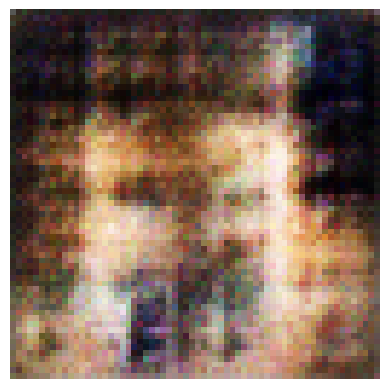

2/2 [==============================] - 5s 3s/step - c_loss: -12.8403 - c_wass_loss: -15.0930 - c_gp: 0.2253 - g_loss: -27.9154
Epoch 16/200
2/2 [==============================] - ETA: 0s - c_loss: -13.3152 - c_wass_loss: -15.8634 - c_gp: 0.2548 - g_loss: -16.8729

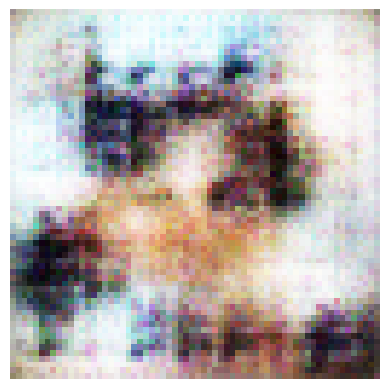

2/2 [==============================] - 5s 3s/step - c_loss: -13.3152 - c_wass_loss: -15.8634 - c_gp: 0.2548 - g_loss: -16.8729
Epoch 17/200
2/2 [==============================] - ETA: 0s - c_loss: -11.9374 - c_wass_loss: -13.8090 - c_gp: 0.1872 - g_loss: -22.1767

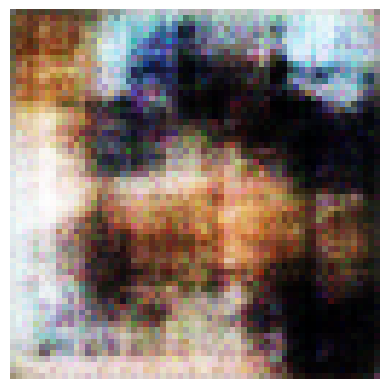

2/2 [==============================] - 5s 3s/step - c_loss: -11.9374 - c_wass_loss: -13.8090 - c_gp: 0.1872 - g_loss: -22.1767
Epoch 18/200
2/2 [==============================] - ETA: 0s - c_loss: -14.8274 - c_wass_loss: -16.9605 - c_gp: 0.2133 - g_loss: -16.3892

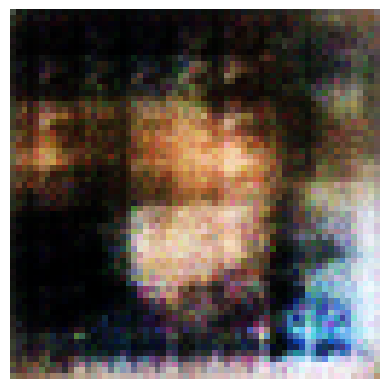

2/2 [==============================] - 5s 3s/step - c_loss: -14.8274 - c_wass_loss: -16.9605 - c_gp: 0.2133 - g_loss: -16.3892
Epoch 19/200
2/2 [==============================] - ETA: 0s - c_loss: -15.2046 - c_wass_loss: -18.2945 - c_gp: 0.3090 - g_loss: -11.8368

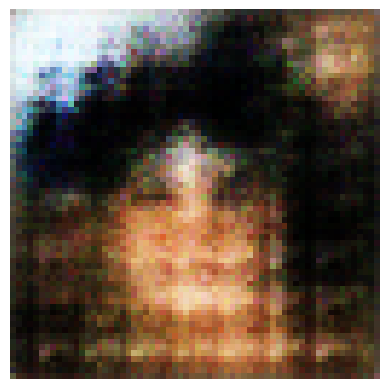

2/2 [==============================] - 5s 3s/step - c_loss: -15.2046 - c_wass_loss: -18.2945 - c_gp: 0.3090 - g_loss: -11.8368
Epoch 20/200
2/2 [==============================] - ETA: 0s - c_loss: -11.2021 - c_wass_loss: -13.1012 - c_gp: 0.1899 - g_loss: -21.2725

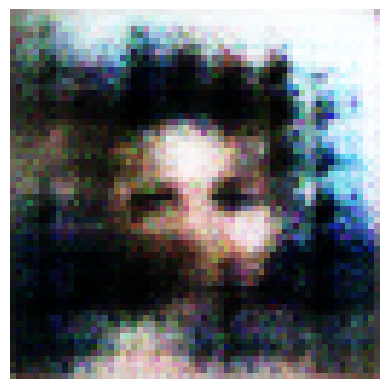

2/2 [==============================] - 5s 3s/step - c_loss: -11.2021 - c_wass_loss: -13.1012 - c_gp: 0.1899 - g_loss: -21.2725
Epoch 21/200
2/2 [==============================] - ETA: 0s - c_loss: -12.7538 - c_wass_loss: -14.8524 - c_gp: 0.2099 - g_loss: 0.0099

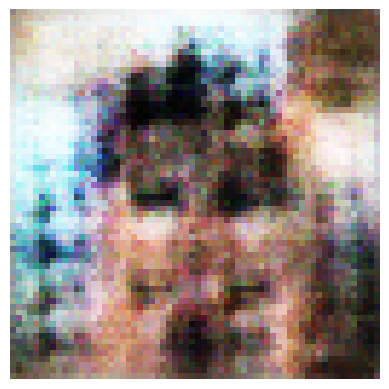

2/2 [==============================] - 5s 3s/step - c_loss: -12.7538 - c_wass_loss: -14.8524 - c_gp: 0.2099 - g_loss: 0.0099
Epoch 22/200
2/2 [==============================] - ETA: 0s - c_loss: -10.8537 - c_wass_loss: -12.3742 - c_gp: 0.1520 - g_loss: -31.9074

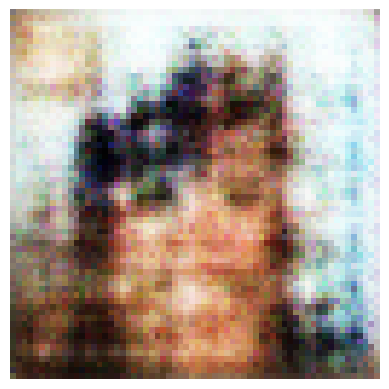

2/2 [==============================] - 5s 3s/step - c_loss: -10.8537 - c_wass_loss: -12.3742 - c_gp: 0.1520 - g_loss: -31.9074
Epoch 23/200
2/2 [==============================] - ETA: 0s - c_loss: -14.0375 - c_wass_loss: -15.5169 - c_gp: 0.1479 - g_loss: -20.2265

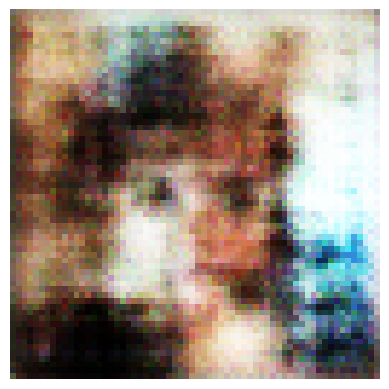

2/2 [==============================] - 5s 3s/step - c_loss: -14.0375 - c_wass_loss: -15.5169 - c_gp: 0.1479 - g_loss: -20.2265
Epoch 24/200
2/2 [==============================] - ETA: 0s - c_loss: -15.9344 - c_wass_loss: -19.4309 - c_gp: 0.3496 - g_loss: -13.4362

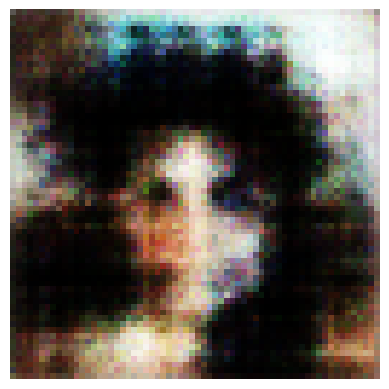

2/2 [==============================] - 5s 3s/step - c_loss: -15.9344 - c_wass_loss: -19.4309 - c_gp: 0.3496 - g_loss: -13.4362
Epoch 25/200
2/2 [==============================] - ETA: 0s - c_loss: -11.3568 - c_wass_loss: -13.2455 - c_gp: 0.1889 - g_loss: -22.3868

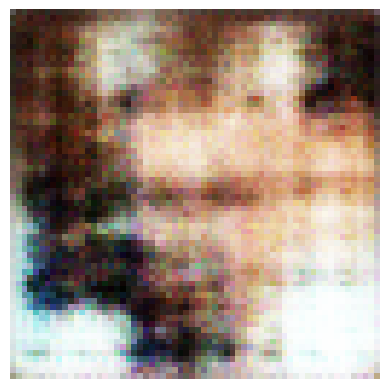

2/2 [==============================] - 5s 3s/step - c_loss: -11.3568 - c_wass_loss: -13.2455 - c_gp: 0.1889 - g_loss: -22.3868
Epoch 26/200
2/2 [==============================] - ETA: 0s - c_loss: -12.9077 - c_wass_loss: -15.0315 - c_gp: 0.2124 - g_loss: -11.3046

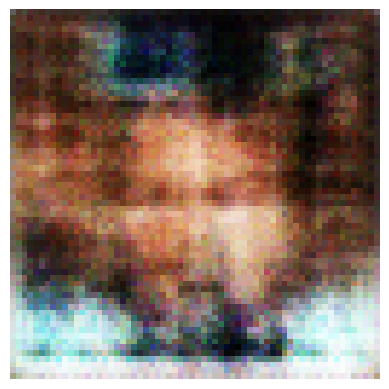

2/2 [==============================] - 5s 3s/step - c_loss: -12.9077 - c_wass_loss: -15.0315 - c_gp: 0.2124 - g_loss: -11.3046
Epoch 27/200
2/2 [==============================] - ETA: 0s - c_loss: -12.7362 - c_wass_loss: -15.0082 - c_gp: 0.2272 - g_loss: -43.8110

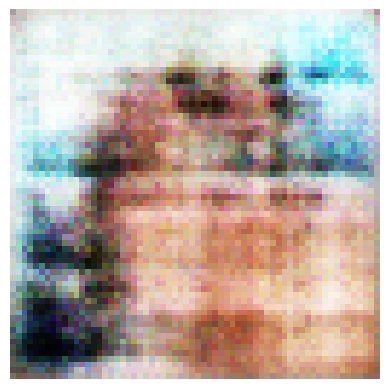

2/2 [==============================] - 5s 3s/step - c_loss: -12.7362 - c_wass_loss: -15.0082 - c_gp: 0.2272 - g_loss: -43.8110
Epoch 28/200
2/2 [==============================] - ETA: 0s - c_loss: -12.9769 - c_wass_loss: -14.6127 - c_gp: 0.1636 - g_loss: -9.7744

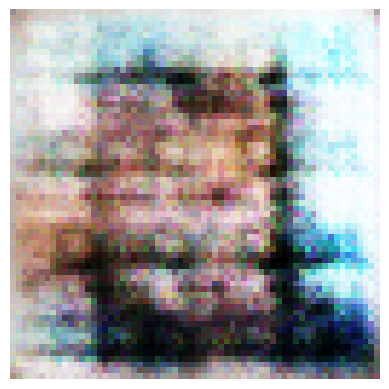

2/2 [==============================] - 5s 3s/step - c_loss: -12.9769 - c_wass_loss: -14.6127 - c_gp: 0.1636 - g_loss: -9.7744
Epoch 29/200
2/2 [==============================] - ETA: 0s - c_loss: -16.9335 - c_wass_loss: -19.8426 - c_gp: 0.2909 - g_loss: -15.1515

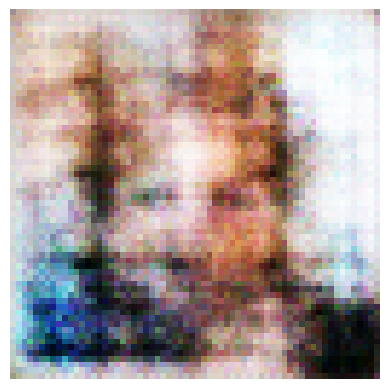

2/2 [==============================] - 5s 3s/step - c_loss: -16.9335 - c_wass_loss: -19.8426 - c_gp: 0.2909 - g_loss: -15.1515
Epoch 30/200
2/2 [==============================] - ETA: 0s - c_loss: -12.8609 - c_wass_loss: -15.6560 - c_gp: 0.2795 - g_loss: -27.9265

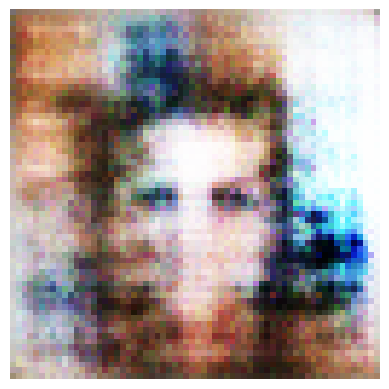

2/2 [==============================] - 5s 3s/step - c_loss: -12.8609 - c_wass_loss: -15.6560 - c_gp: 0.2795 - g_loss: -27.9265
Epoch 31/200
2/2 [==============================] - ETA: 0s - c_loss: -11.5922 - c_wass_loss: -13.3549 - c_gp: 0.1763 - g_loss: -6.6541 

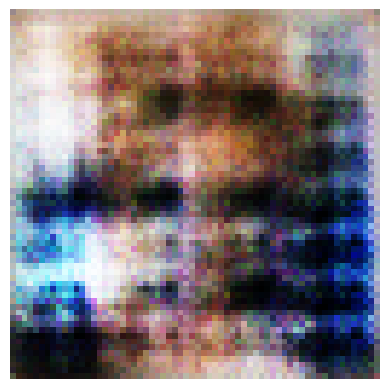

2/2 [==============================] - 5s 3s/step - c_loss: -11.5922 - c_wass_loss: -13.3549 - c_gp: 0.1763 - g_loss: -6.6541
Epoch 32/200
2/2 [==============================] - ETA: 0s - c_loss: -14.0634 - c_wass_loss: -16.4317 - c_gp: 0.2368 - g_loss: -25.6679

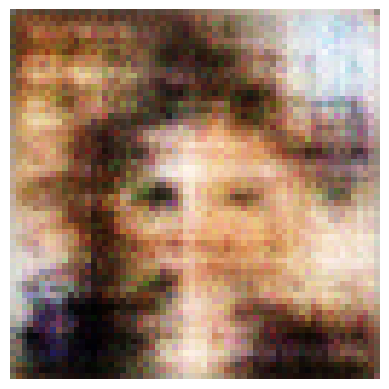

2/2 [==============================] - 5s 3s/step - c_loss: -14.0634 - c_wass_loss: -16.4317 - c_gp: 0.2368 - g_loss: -25.6679
Epoch 33/200
2/2 [==============================] - ETA: 0s - c_loss: -13.1868 - c_wass_loss: -15.5948 - c_gp: 0.2408 - g_loss: -35.2193

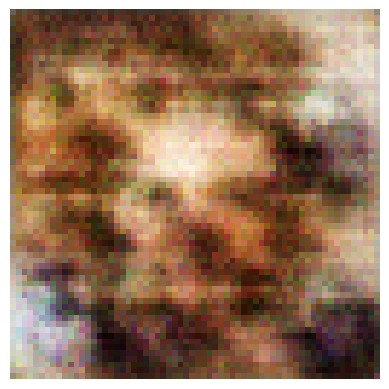

2/2 [==============================] - 5s 3s/step - c_loss: -13.1868 - c_wass_loss: -15.5948 - c_gp: 0.2408 - g_loss: -35.2193
Epoch 34/200
2/2 [==============================] - ETA: 0s - c_loss: -11.7819 - c_wass_loss: -13.6754 - c_gp: 0.1894 - g_loss: -41.5653

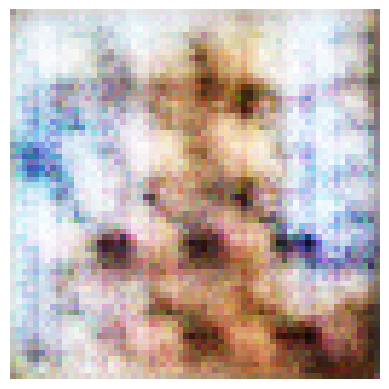

2/2 [==============================] - 5s 3s/step - c_loss: -11.7819 - c_wass_loss: -13.6754 - c_gp: 0.1894 - g_loss: -41.5653
Epoch 35/200
2/2 [==============================] - ETA: 0s - c_loss: -14.6500 - c_wass_loss: -17.2620 - c_gp: 0.2612 - g_loss: -35.1164

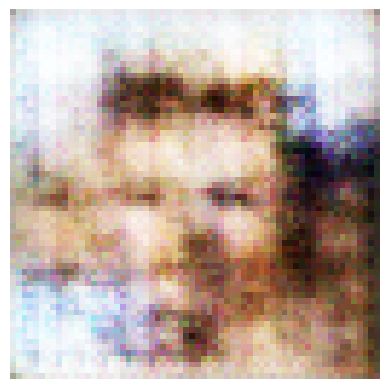

2/2 [==============================] - 5s 3s/step - c_loss: -14.6500 - c_wass_loss: -17.2620 - c_gp: 0.2612 - g_loss: -35.1164
Epoch 36/200
2/2 [==============================] - ETA: 0s - c_loss: -14.6284 - c_wass_loss: -17.6053 - c_gp: 0.2977 - g_loss: -33.9409

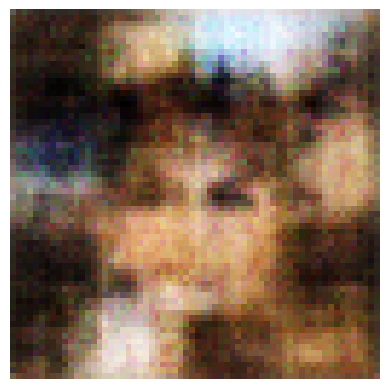

2/2 [==============================] - 5s 3s/step - c_loss: -14.6284 - c_wass_loss: -17.6053 - c_gp: 0.2977 - g_loss: -33.9409
Epoch 37/200
2/2 [==============================] - ETA: 0s - c_loss: -13.3245 - c_wass_loss: -15.4766 - c_gp: 0.2152 - g_loss: -27.6236

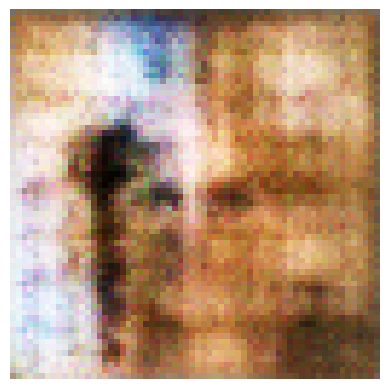

2/2 [==============================] - 5s 3s/step - c_loss: -13.3245 - c_wass_loss: -15.4766 - c_gp: 0.2152 - g_loss: -27.6236
Epoch 38/200
2/2 [==============================] - ETA: 0s - c_loss: -12.2598 - c_wass_loss: -14.3982 - c_gp: 0.2138 - g_loss: -39.0678

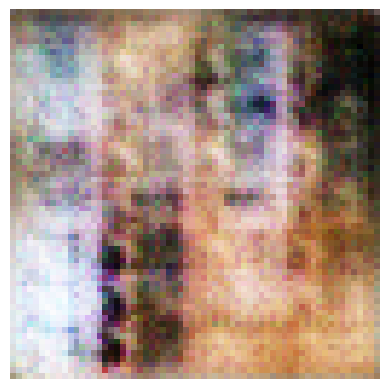

2/2 [==============================] - 5s 3s/step - c_loss: -12.2598 - c_wass_loss: -14.3982 - c_gp: 0.2138 - g_loss: -39.0678
Epoch 39/200
2/2 [==============================] - ETA: 0s - c_loss: -12.2556 - c_wass_loss: -14.2089 - c_gp: 0.1953 - g_loss: -46.5080

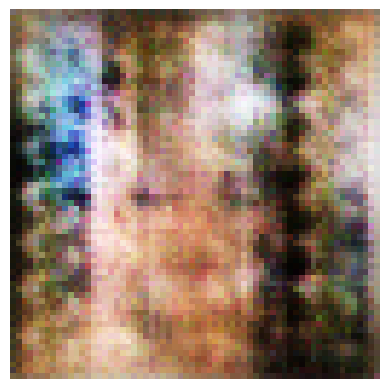

2/2 [==============================] - 5s 3s/step - c_loss: -12.2556 - c_wass_loss: -14.2089 - c_gp: 0.1953 - g_loss: -46.5080
Epoch 40/200
2/2 [==============================] - ETA: 0s - c_loss: -14.1426 - c_wass_loss: -16.6682 - c_gp: 0.2526 - g_loss: -54.9740

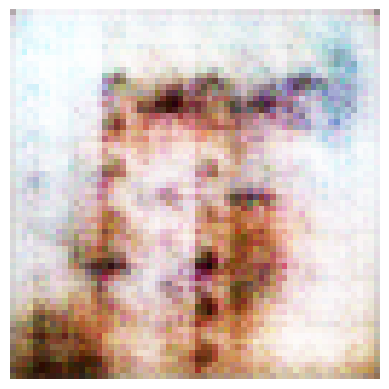

2/2 [==============================] - 5s 3s/step - c_loss: -14.1426 - c_wass_loss: -16.6682 - c_gp: 0.2526 - g_loss: -54.9740
Epoch 41/200
2/2 [==============================] - ETA: 0s - c_loss: -14.3062 - c_wass_loss: -17.0001 - c_gp: 0.2694 - g_loss: -20.0793

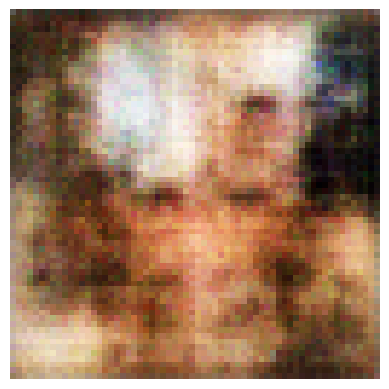

2/2 [==============================] - 5s 3s/step - c_loss: -14.3062 - c_wass_loss: -17.0001 - c_gp: 0.2694 - g_loss: -20.0793
Epoch 42/200
2/2 [==============================] - ETA: 0s - c_loss: -13.1959 - c_wass_loss: -15.7030 - c_gp: 0.2507 - g_loss: -31.3154

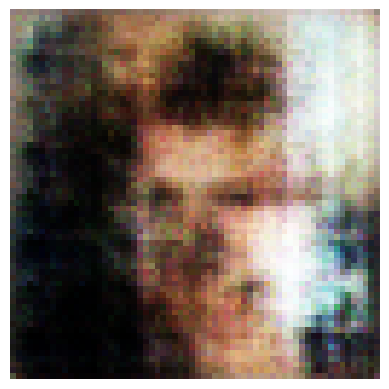

2/2 [==============================] - 5s 3s/step - c_loss: -13.1959 - c_wass_loss: -15.7030 - c_gp: 0.2507 - g_loss: -31.3154
Epoch 43/200
2/2 [==============================] - ETA: 0s - c_loss: -12.1071 - c_wass_loss: -14.2069 - c_gp: 0.2100 - g_loss: -50.0098

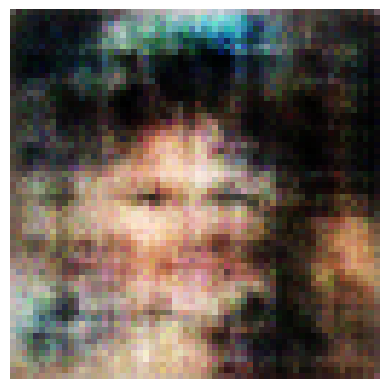

2/2 [==============================] - 5s 3s/step - c_loss: -12.1071 - c_wass_loss: -14.2069 - c_gp: 0.2100 - g_loss: -50.0098
Epoch 44/200
2/2 [==============================] - ETA: 0s - c_loss: -11.8350 - c_wass_loss: -13.9041 - c_gp: 0.2069 - g_loss: -45.5095

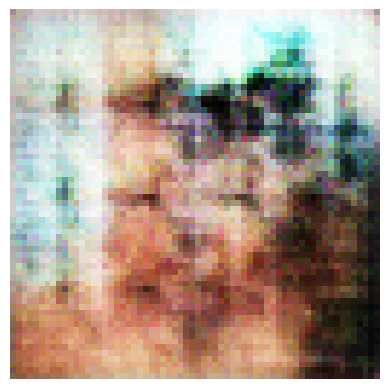

2/2 [==============================] - 5s 3s/step - c_loss: -11.8350 - c_wass_loss: -13.9041 - c_gp: 0.2069 - g_loss: -45.5095
Epoch 45/200
2/2 [==============================] - ETA: 0s - c_loss: -13.1534 - c_wass_loss: -14.9624 - c_gp: 0.1809 - g_loss: -50.9532

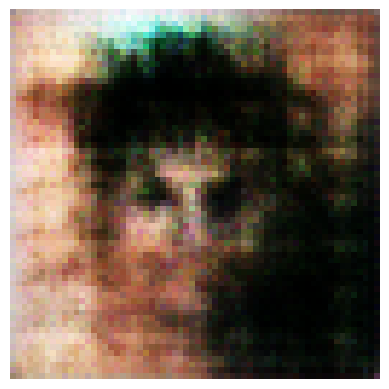

2/2 [==============================] - 5s 3s/step - c_loss: -13.1534 - c_wass_loss: -14.9624 - c_gp: 0.1809 - g_loss: -50.9532
Epoch 46/200
2/2 [==============================] - ETA: 0s - c_loss: -13.5945 - c_wass_loss: -15.7431 - c_gp: 0.2149 - g_loss: -37.6802

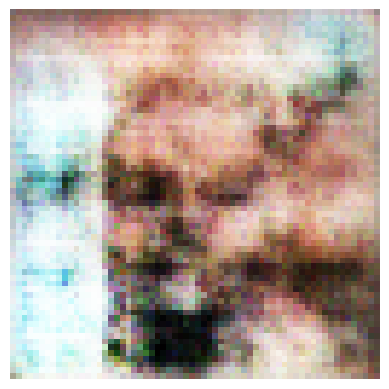

2/2 [==============================] - 5s 3s/step - c_loss: -13.5945 - c_wass_loss: -15.7431 - c_gp: 0.2149 - g_loss: -37.6802
Epoch 47/200
2/2 [==============================] - ETA: 0s - c_loss: -12.9151 - c_wass_loss: -15.4307 - c_gp: 0.2516 - g_loss: -26.0982

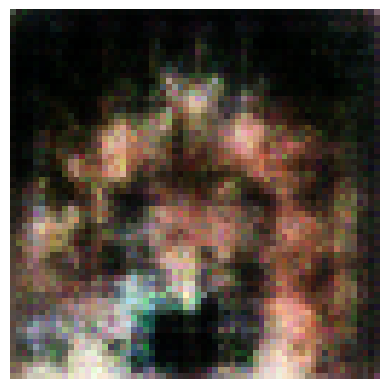

2/2 [==============================] - 5s 3s/step - c_loss: -12.9151 - c_wass_loss: -15.4307 - c_gp: 0.2516 - g_loss: -26.0982
Epoch 48/200
2/2 [==============================] - ETA: 0s - c_loss: -13.9752 - c_wass_loss: -16.8282 - c_gp: 0.2853 - g_loss: -40.0350

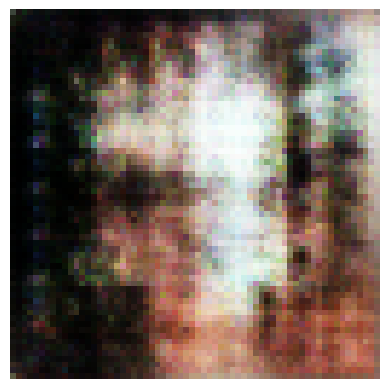

2/2 [==============================] - 5s 3s/step - c_loss: -13.9752 - c_wass_loss: -16.8282 - c_gp: 0.2853 - g_loss: -40.0350
Epoch 49/200
2/2 [==============================] - ETA: 0s - c_loss: -12.4124 - c_wass_loss: -14.3681 - c_gp: 0.1956 - g_loss: -46.2893

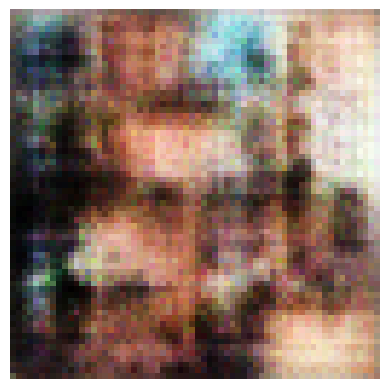

2/2 [==============================] - 5s 3s/step - c_loss: -12.4124 - c_wass_loss: -14.3681 - c_gp: 0.1956 - g_loss: -46.2893
Epoch 50/200
2/2 [==============================] - ETA: 0s - c_loss: -11.9163 - c_wass_loss: -13.7341 - c_gp: 0.1818 - g_loss: -46.5397

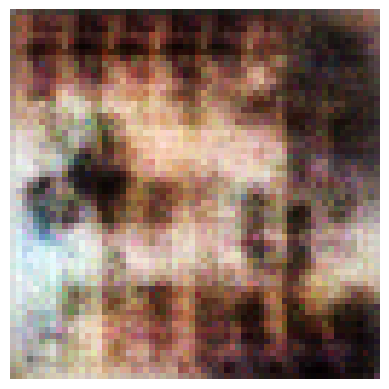

2/2 [==============================] - 5s 3s/step - c_loss: -11.9163 - c_wass_loss: -13.7341 - c_gp: 0.1818 - g_loss: -46.5397
Epoch 51/200
2/2 [==============================] - ETA: 0s - c_loss: -13.7854 - c_wass_loss: -15.8390 - c_gp: 0.2054 - g_loss: -31.9164

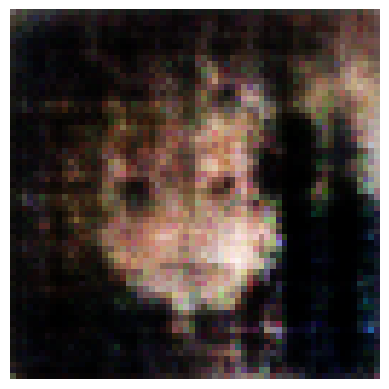

2/2 [==============================] - 5s 3s/step - c_loss: -13.7854 - c_wass_loss: -15.8390 - c_gp: 0.2054 - g_loss: -31.9164
Epoch 52/200
2/2 [==============================] - ETA: 0s - c_loss: -12.6146 - c_wass_loss: -15.0858 - c_gp: 0.2471 - g_loss: -35.1275

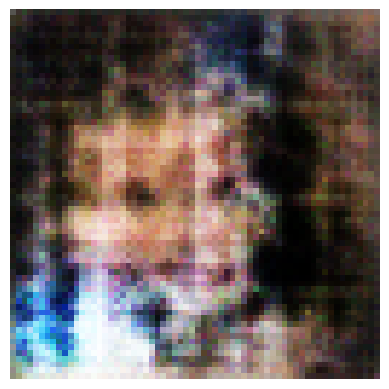

2/2 [==============================] - 5s 3s/step - c_loss: -12.6146 - c_wass_loss: -15.0858 - c_gp: 0.2471 - g_loss: -35.1275
Epoch 53/200
2/2 [==============================] - ETA: 0s - c_loss: -13.3929 - c_wass_loss: -16.0036 - c_gp: 0.2611 - g_loss: -30.9044

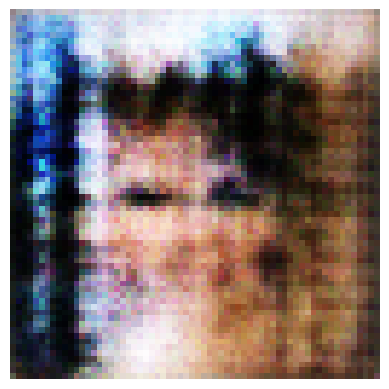

2/2 [==============================] - 5s 3s/step - c_loss: -13.3929 - c_wass_loss: -16.0036 - c_gp: 0.2611 - g_loss: -30.9044
Epoch 54/200
2/2 [==============================] - ETA: 0s - c_loss: -13.4927 - c_wass_loss: -16.0189 - c_gp: 0.2526 - g_loss: -27.6518

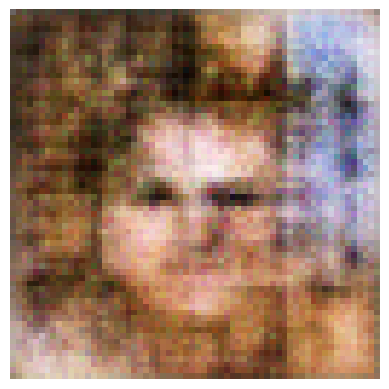

2/2 [==============================] - 5s 3s/step - c_loss: -13.4927 - c_wass_loss: -16.0189 - c_gp: 0.2526 - g_loss: -27.6518
Epoch 55/200
2/2 [==============================] - ETA: 0s - c_loss: -12.4558 - c_wass_loss: -14.5852 - c_gp: 0.2129 - g_loss: -59.7488

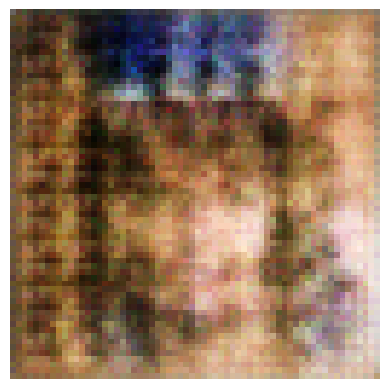

2/2 [==============================] - 5s 3s/step - c_loss: -12.4558 - c_wass_loss: -14.5852 - c_gp: 0.2129 - g_loss: -59.7488
Epoch 56/200
2/2 [==============================] - ETA: 0s - c_loss: -12.6129 - c_wass_loss: -14.5542 - c_gp: 0.1941 - g_loss: -44.7404

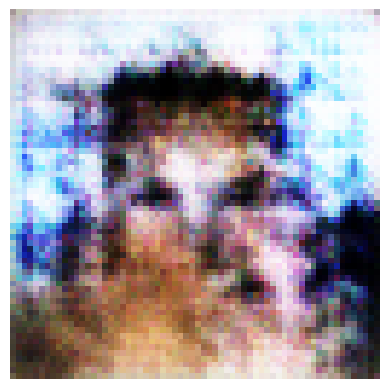

2/2 [==============================] - 5s 3s/step - c_loss: -12.6129 - c_wass_loss: -14.5542 - c_gp: 0.1941 - g_loss: -44.7404
Epoch 57/200
2/2 [==============================] - ETA: 0s - c_loss: -13.6862 - c_wass_loss: -16.1346 - c_gp: 0.2448 - g_loss: -36.3897

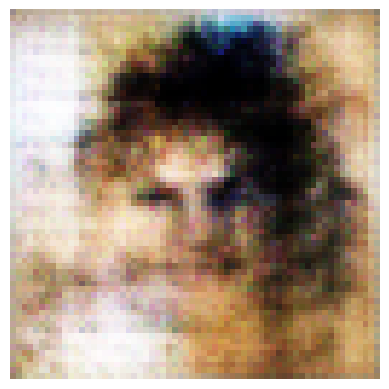

2/2 [==============================] - 5s 3s/step - c_loss: -13.6862 - c_wass_loss: -16.1346 - c_gp: 0.2448 - g_loss: -36.3897
Epoch 58/200
2/2 [==============================] - ETA: 0s - c_loss: -13.5200 - c_wass_loss: -15.8047 - c_gp: 0.2285 - g_loss: -48.1752

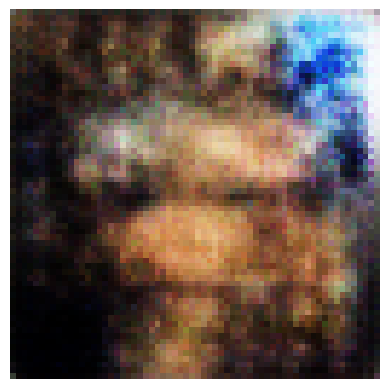

2/2 [==============================] - 5s 3s/step - c_loss: -13.5200 - c_wass_loss: -15.8047 - c_gp: 0.2285 - g_loss: -48.1752
Epoch 59/200
2/2 [==============================] - ETA: 0s - c_loss: -12.9013 - c_wass_loss: -15.0164 - c_gp: 0.2115 - g_loss: -44.8531

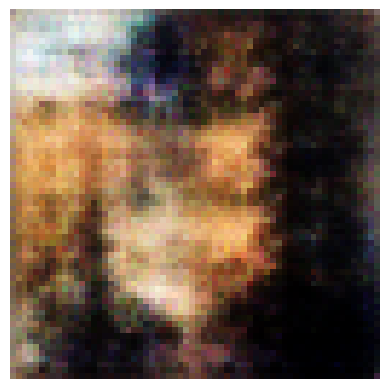

2/2 [==============================] - 5s 3s/step - c_loss: -12.9013 - c_wass_loss: -15.0164 - c_gp: 0.2115 - g_loss: -44.8531
Epoch 60/200
2/2 [==============================] - ETA: 0s - c_loss: -13.6165 - c_wass_loss: -15.9170 - c_gp: 0.2301 - g_loss: -35.5225

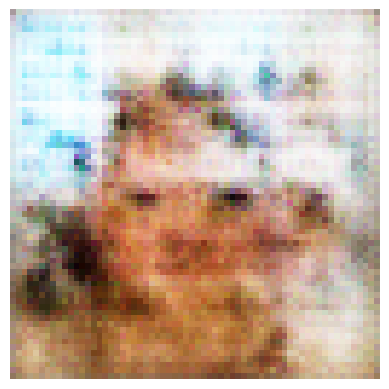

2/2 [==============================] - 5s 3s/step - c_loss: -13.6165 - c_wass_loss: -15.9170 - c_gp: 0.2301 - g_loss: -35.5225
Epoch 61/200
2/2 [==============================] - ETA: 0s - c_loss: -13.5277 - c_wass_loss: -16.0346 - c_gp: 0.2507 - g_loss: -49.6063

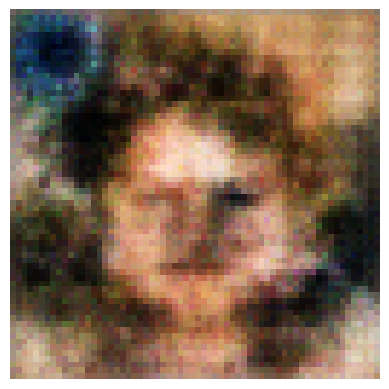

2/2 [==============================] - 5s 3s/step - c_loss: -13.5277 - c_wass_loss: -16.0346 - c_gp: 0.2507 - g_loss: -49.6063
Epoch 62/200
2/2 [==============================] - ETA: 0s - c_loss: -12.0540 - c_wass_loss: -13.9081 - c_gp: 0.1854 - g_loss: -57.4973

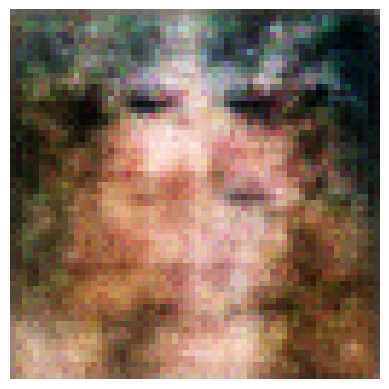

2/2 [==============================] - 5s 3s/step - c_loss: -12.0540 - c_wass_loss: -13.9081 - c_gp: 0.1854 - g_loss: -57.4973
Epoch 63/200
2/2 [==============================] - ETA: 0s - c_loss: -12.5000 - c_wass_loss: -14.4602 - c_gp: 0.1960 - g_loss: -56.3178

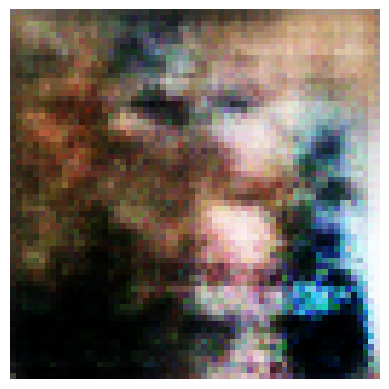

2/2 [==============================] - 5s 3s/step - c_loss: -12.5000 - c_wass_loss: -14.4602 - c_gp: 0.1960 - g_loss: -56.3178
Epoch 64/200
2/2 [==============================] - ETA: 0s - c_loss: -13.0418 - c_wass_loss: -15.1249 - c_gp: 0.2083 - g_loss: -54.4065

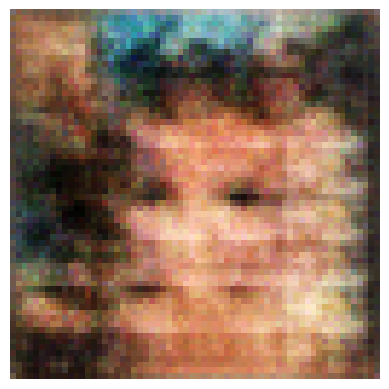

2/2 [==============================] - 5s 3s/step - c_loss: -13.0418 - c_wass_loss: -15.1249 - c_gp: 0.2083 - g_loss: -54.4065
Epoch 65/200
2/2 [==============================] - ETA: 0s - c_loss: -13.9203 - c_wass_loss: -16.5010 - c_gp: 0.2581 - g_loss: -51.2853

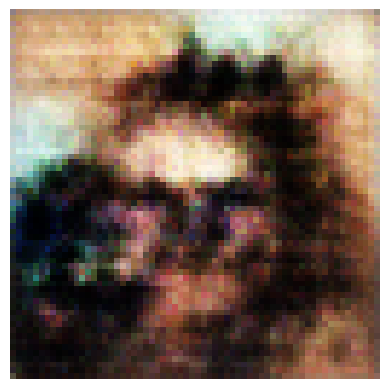

2/2 [==============================] - 5s 3s/step - c_loss: -13.9203 - c_wass_loss: -16.5010 - c_gp: 0.2581 - g_loss: -51.2853
Epoch 66/200
2/2 [==============================] - ETA: 0s - c_loss: -12.3912 - c_wass_loss: -14.4989 - c_gp: 0.2108 - g_loss: -51.6885

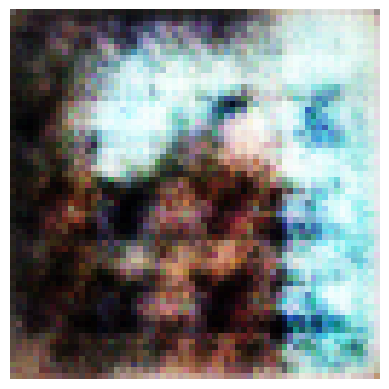

2/2 [==============================] - 5s 3s/step - c_loss: -12.3912 - c_wass_loss: -14.4989 - c_gp: 0.2108 - g_loss: -51.6885
Epoch 67/200
2/2 [==============================] - ETA: 0s - c_loss: -14.3760 - c_wass_loss: -16.8172 - c_gp: 0.2441 - g_loss: -40.2843

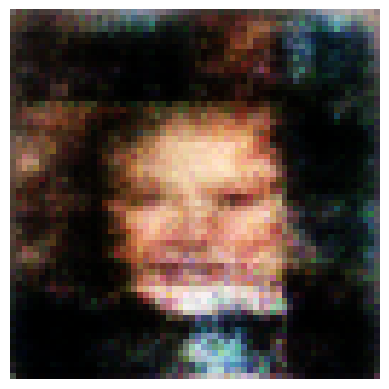

2/2 [==============================] - 5s 3s/step - c_loss: -14.3760 - c_wass_loss: -16.8172 - c_gp: 0.2441 - g_loss: -40.2843
Epoch 68/200
2/2 [==============================] - ETA: 0s - c_loss: -13.5960 - c_wass_loss: -16.4689 - c_gp: 0.2873 - g_loss: -52.1376

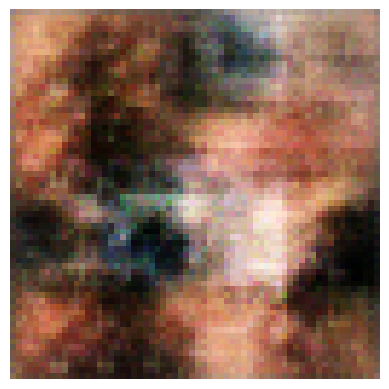

2/2 [==============================] - 5s 3s/step - c_loss: -13.5960 - c_wass_loss: -16.4689 - c_gp: 0.2873 - g_loss: -52.1376
Epoch 69/200
2/2 [==============================] - ETA: 0s - c_loss: -12.5278 - c_wass_loss: -14.7576 - c_gp: 0.2230 - g_loss: -59.8481

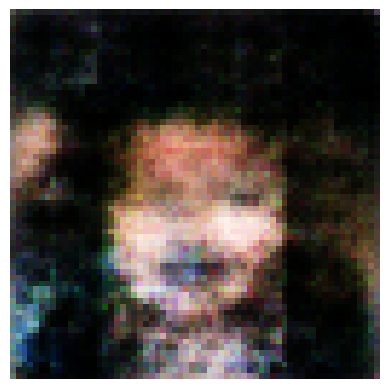

2/2 [==============================] - 5s 3s/step - c_loss: -12.5278 - c_wass_loss: -14.7576 - c_gp: 0.2230 - g_loss: -59.8481
Epoch 70/200
2/2 [==============================] - ETA: 0s - c_loss: -13.5499 - c_wass_loss: -15.5997 - c_gp: 0.2050 - g_loss: -66.9134

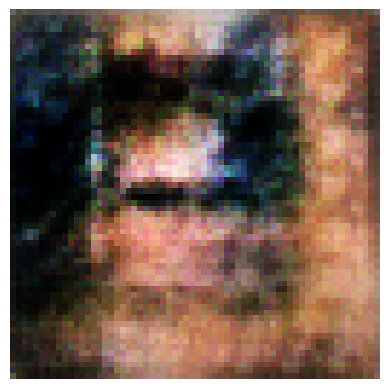

2/2 [==============================] - 5s 3s/step - c_loss: -13.5499 - c_wass_loss: -15.5997 - c_gp: 0.2050 - g_loss: -66.9134
Epoch 71/200
2/2 [==============================] - ETA: 0s - c_loss: -12.7996 - c_wass_loss: -15.1907 - c_gp: 0.2391 - g_loss: -62.1487

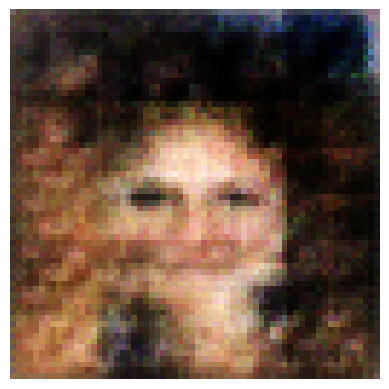

2/2 [==============================] - 5s 3s/step - c_loss: -12.7996 - c_wass_loss: -15.1907 - c_gp: 0.2391 - g_loss: -62.1487
Epoch 72/200
2/2 [==============================] - ETA: 0s - c_loss: -11.7507 - c_wass_loss: -13.4967 - c_gp: 0.1746 - g_loss: -49.9488

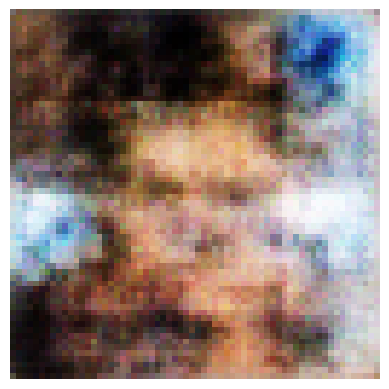

2/2 [==============================] - 5s 3s/step - c_loss: -11.7507 - c_wass_loss: -13.4967 - c_gp: 0.1746 - g_loss: -49.9488
Epoch 73/200
2/2 [==============================] - ETA: 0s - c_loss: -12.7823 - c_wass_loss: -14.6152 - c_gp: 0.1833 - g_loss: -46.7852

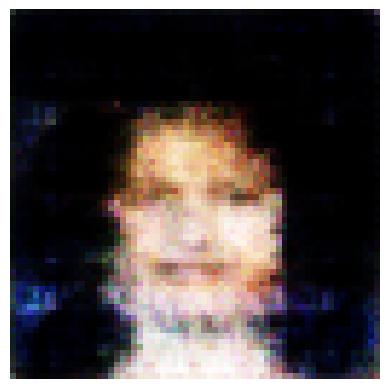

2/2 [==============================] - 5s 3s/step - c_loss: -12.7823 - c_wass_loss: -14.6152 - c_gp: 0.1833 - g_loss: -46.7852
Epoch 74/200
2/2 [==============================] - ETA: 0s - c_loss: -13.6937 - c_wass_loss: -16.3932 - c_gp: 0.2699 - g_loss: -50.8379

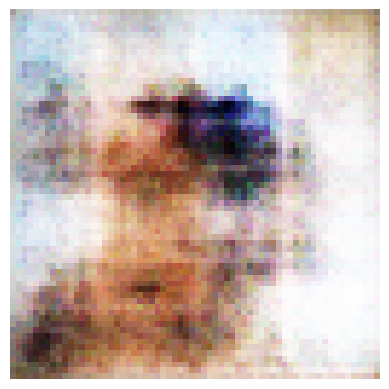

2/2 [==============================] - 5s 3s/step - c_loss: -13.6937 - c_wass_loss: -16.3932 - c_gp: 0.2699 - g_loss: -50.8379
Epoch 75/200
2/2 [==============================] - ETA: 0s - c_loss: -12.8598 - c_wass_loss: -15.1610 - c_gp: 0.2301 - g_loss: -39.9708

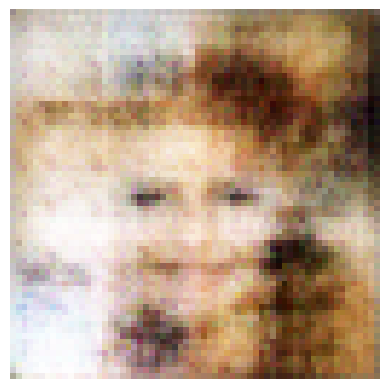

2/2 [==============================] - 5s 3s/step - c_loss: -12.8598 - c_wass_loss: -15.1610 - c_gp: 0.2301 - g_loss: -39.9708
Epoch 76/200
2/2 [==============================] - ETA: 0s - c_loss: -13.0782 - c_wass_loss: -15.4050 - c_gp: 0.2327 - g_loss: -48.1912

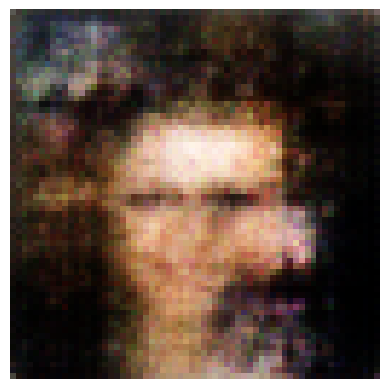

2/2 [==============================] - 5s 3s/step - c_loss: -13.0782 - c_wass_loss: -15.4050 - c_gp: 0.2327 - g_loss: -48.1912
Epoch 77/200
2/2 [==============================] - ETA: 0s - c_loss: -11.2753 - c_wass_loss: -12.9850 - c_gp: 0.1710 - g_loss: -38.5253

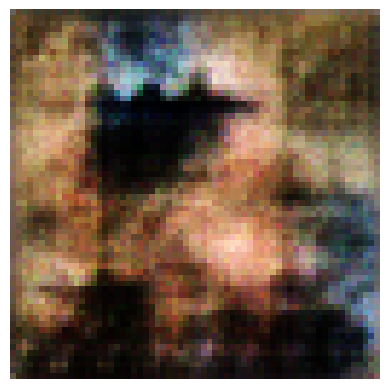

2/2 [==============================] - 5s 3s/step - c_loss: -11.2753 - c_wass_loss: -12.9850 - c_gp: 0.1710 - g_loss: -38.5253
Epoch 78/200
2/2 [==============================] - ETA: 0s - c_loss: -12.1064 - c_wass_loss: -13.8953 - c_gp: 0.1789 - g_loss: -46.1524

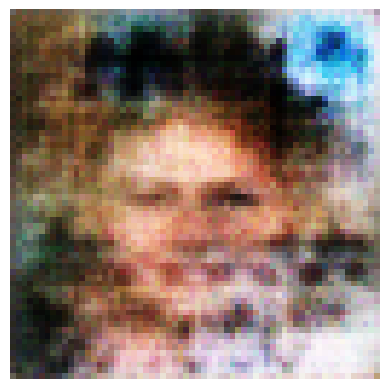

2/2 [==============================] - 5s 3s/step - c_loss: -12.1064 - c_wass_loss: -13.8953 - c_gp: 0.1789 - g_loss: -46.1524
Epoch 79/200
2/2 [==============================] - ETA: 0s - c_loss: -11.8584 - c_wass_loss: -13.8884 - c_gp: 0.2030 - g_loss: -55.1440

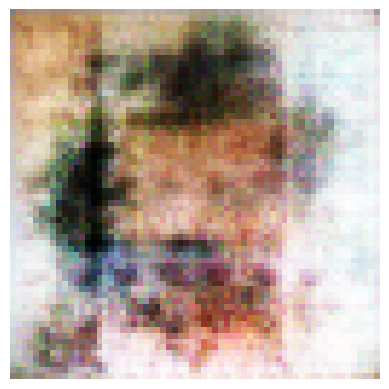

2/2 [==============================] - 5s 3s/step - c_loss: -11.8584 - c_wass_loss: -13.8884 - c_gp: 0.2030 - g_loss: -55.1440
Epoch 80/200
2/2 [==============================] - ETA: 0s - c_loss: -13.0840 - c_wass_loss: -15.2860 - c_gp: 0.2202 - g_loss: -65.3726

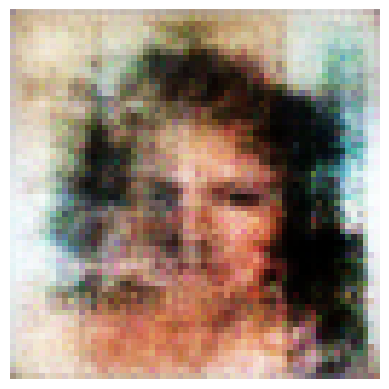

2/2 [==============================] - 5s 3s/step - c_loss: -13.0840 - c_wass_loss: -15.2860 - c_gp: 0.2202 - g_loss: -65.3726
Epoch 81/200
2/2 [==============================] - ETA: 0s - c_loss: -11.7151 - c_wass_loss: -14.1070 - c_gp: 0.2392 - g_loss: -50.2168

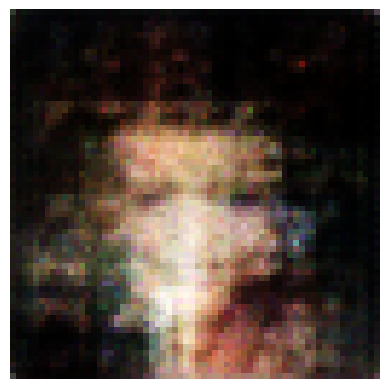

2/2 [==============================] - 5s 3s/step - c_loss: -11.7151 - c_wass_loss: -14.1070 - c_gp: 0.2392 - g_loss: -50.2168
Epoch 82/200
2/2 [==============================] - ETA: 0s - c_loss: -10.8330 - c_wass_loss: -12.6930 - c_gp: 0.1860 - g_loss: -45.7505

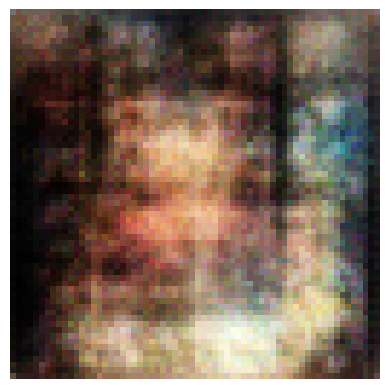

2/2 [==============================] - 5s 3s/step - c_loss: -10.8330 - c_wass_loss: -12.6930 - c_gp: 0.1860 - g_loss: -45.7505
Epoch 83/200
2/2 [==============================] - ETA: 0s - c_loss: -12.2518 - c_wass_loss: -13.9403 - c_gp: 0.1688 - g_loss: -46.7922

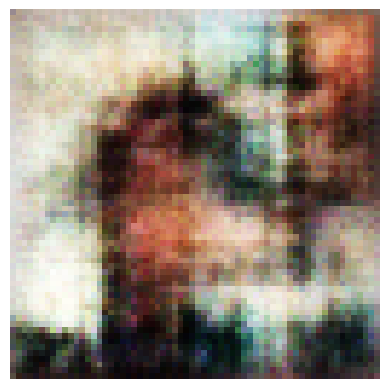

2/2 [==============================] - 5s 3s/step - c_loss: -12.2518 - c_wass_loss: -13.9403 - c_gp: 0.1688 - g_loss: -46.7922
Epoch 84/200
2/2 [==============================] - ETA: 0s - c_loss: -12.3587 - c_wass_loss: -14.4365 - c_gp: 0.2078 - g_loss: -52.0546

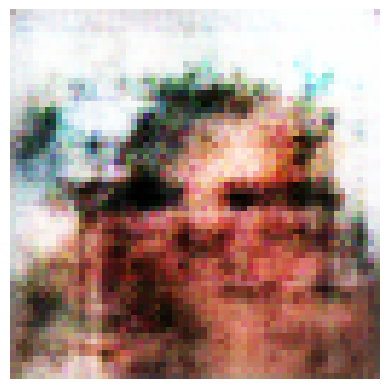

2/2 [==============================] - 5s 3s/step - c_loss: -12.3587 - c_wass_loss: -14.4365 - c_gp: 0.2078 - g_loss: -52.0546
Epoch 85/200
2/2 [==============================] - ETA: 0s - c_loss: -10.7980 - c_wass_loss: -12.4281 - c_gp: 0.1630 - g_loss: -51.7135

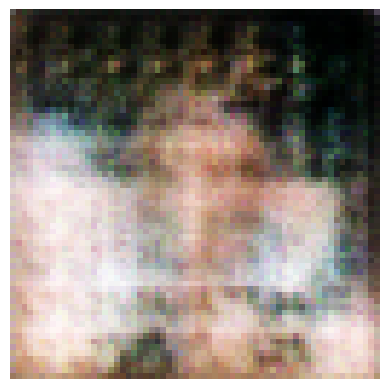

2/2 [==============================] - 5s 3s/step - c_loss: -10.7980 - c_wass_loss: -12.4281 - c_gp: 0.1630 - g_loss: -51.7135
Epoch 86/200
2/2 [==============================] - ETA: 0s - c_loss: -12.0943 - c_wass_loss: -14.1914 - c_gp: 0.2097 - g_loss: -47.1534

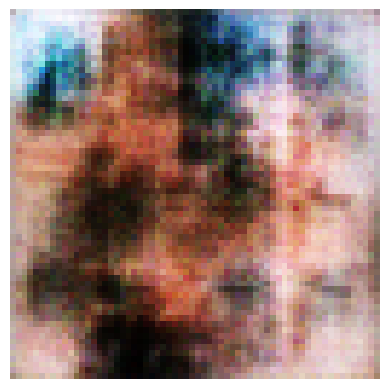

2/2 [==============================] - 5s 3s/step - c_loss: -12.0943 - c_wass_loss: -14.1914 - c_gp: 0.2097 - g_loss: -47.1534
Epoch 87/200
2/2 [==============================] - ETA: 0s - c_loss: -11.1396 - c_wass_loss: -13.2817 - c_gp: 0.2142 - g_loss: -45.4076

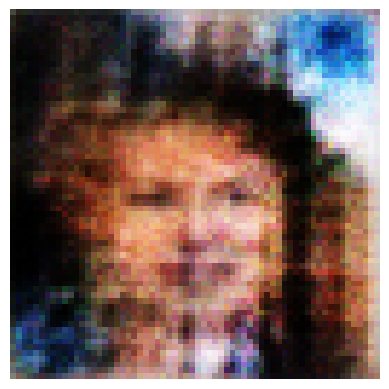

2/2 [==============================] - 5s 3s/step - c_loss: -11.1396 - c_wass_loss: -13.2817 - c_gp: 0.2142 - g_loss: -45.4076
Epoch 88/200
2/2 [==============================] - ETA: 0s - c_loss: -11.0904 - c_wass_loss: -12.8093 - c_gp: 0.1719 - g_loss: -41.4388

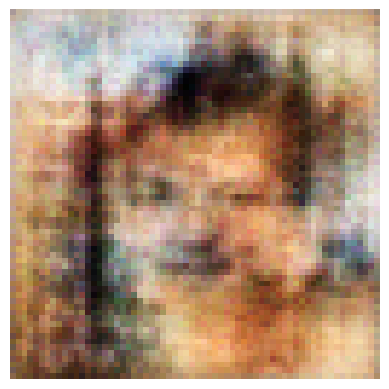

2/2 [==============================] - 5s 3s/step - c_loss: -11.0904 - c_wass_loss: -12.8093 - c_gp: 0.1719 - g_loss: -41.4388
Epoch 89/200
2/2 [==============================] - ETA: 0s - c_loss: -11.7901 - c_wass_loss: -13.4788 - c_gp: 0.1689 - g_loss: -47.0945

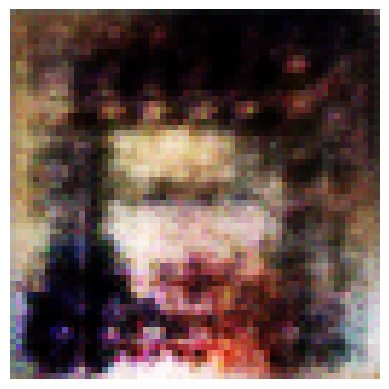

2/2 [==============================] - 5s 3s/step - c_loss: -11.7901 - c_wass_loss: -13.4788 - c_gp: 0.1689 - g_loss: -47.0945
Epoch 90/200
2/2 [==============================] - ETA: 0s - c_loss: -11.3237 - c_wass_loss: -13.1768 - c_gp: 0.1853 - g_loss: -47.2708

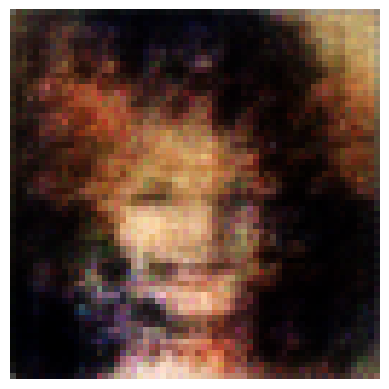

2/2 [==============================] - 5s 3s/step - c_loss: -11.3237 - c_wass_loss: -13.1768 - c_gp: 0.1853 - g_loss: -47.2708
Epoch 91/200
2/2 [==============================] - ETA: 0s - c_loss: -12.1604 - c_wass_loss: -14.4058 - c_gp: 0.2245 - g_loss: -35.1437

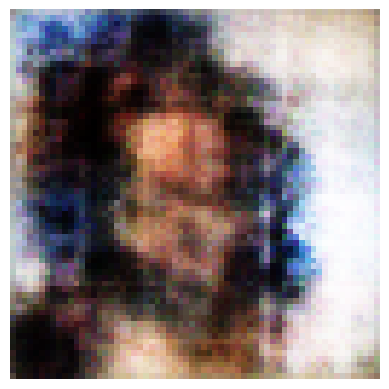

2/2 [==============================] - 5s 3s/step - c_loss: -12.1604 - c_wass_loss: -14.4058 - c_gp: 0.2245 - g_loss: -35.1437
Epoch 92/200
2/2 [==============================] - ETA: 0s - c_loss: -10.9085 - c_wass_loss: -12.8527 - c_gp: 0.1944 - g_loss: -33.5281

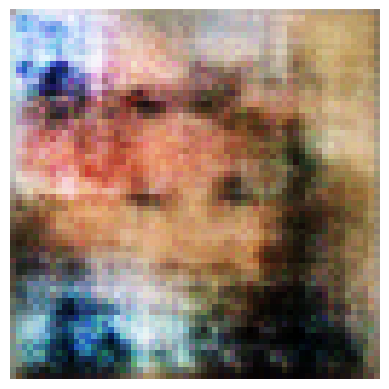

2/2 [==============================] - 5s 3s/step - c_loss: -10.9085 - c_wass_loss: -12.8527 - c_gp: 0.1944 - g_loss: -33.5281
Epoch 93/200
2/2 [==============================] - ETA: 0s - c_loss: -11.3828 - c_wass_loss: -13.5554 - c_gp: 0.2173 - g_loss: -47.2568

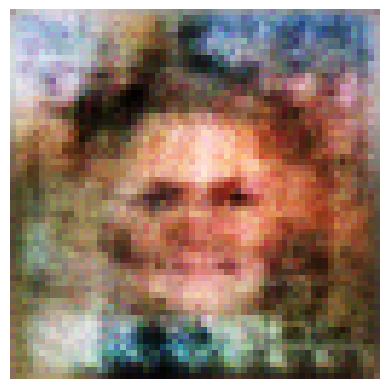

2/2 [==============================] - 5s 3s/step - c_loss: -11.3828 - c_wass_loss: -13.5554 - c_gp: 0.2173 - g_loss: -47.2568
Epoch 94/200
2/2 [==============================] - ETA: 0s - c_loss: -10.6651 - c_wass_loss: -12.0035 - c_gp: 0.1338 - g_loss: -44.3061

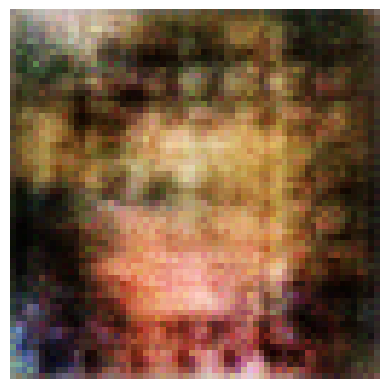

2/2 [==============================] - 5s 3s/step - c_loss: -10.6651 - c_wass_loss: -12.0035 - c_gp: 0.1338 - g_loss: -44.3061
Epoch 95/200
2/2 [==============================] - ETA: 0s - c_loss: -12.9558 - c_wass_loss: -15.2067 - c_gp: 0.2251 - g_loss: -48.8324

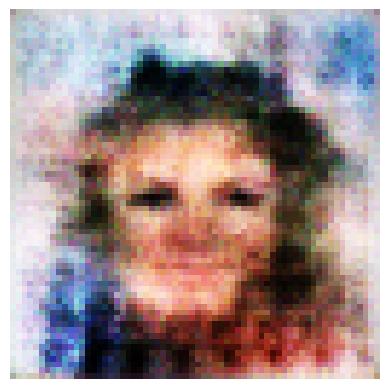

2/2 [==============================] - 5s 3s/step - c_loss: -12.9558 - c_wass_loss: -15.2067 - c_gp: 0.2251 - g_loss: -48.8324
Epoch 96/200
2/2 [==============================] - ETA: 0s - c_loss: -11.5947 - c_wass_loss: -13.2933 - c_gp: 0.1699 - g_loss: -53.4949

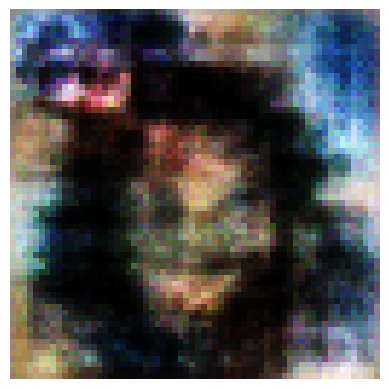

2/2 [==============================] - 5s 3s/step - c_loss: -11.5947 - c_wass_loss: -13.2933 - c_gp: 0.1699 - g_loss: -53.4949
Epoch 97/200
2/2 [==============================] - ETA: 0s - c_loss: -11.8308 - c_wass_loss: -13.8959 - c_gp: 0.2065 - g_loss: -46.6210

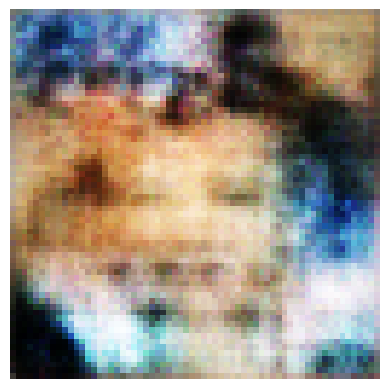

2/2 [==============================] - 5s 3s/step - c_loss: -11.8308 - c_wass_loss: -13.8959 - c_gp: 0.2065 - g_loss: -46.6210
Epoch 98/200
2/2 [==============================] - ETA: 0s - c_loss: -10.7599 - c_wass_loss: -12.2669 - c_gp: 0.1507 - g_loss: -47.8308

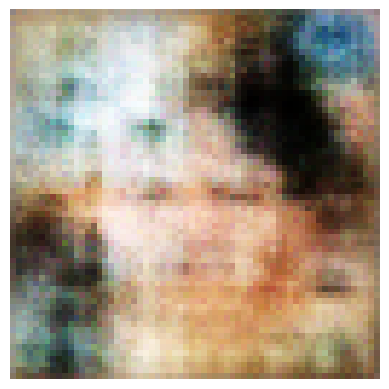

2/2 [==============================] - 5s 3s/step - c_loss: -10.7599 - c_wass_loss: -12.2669 - c_gp: 0.1507 - g_loss: -47.8308
Epoch 99/200
2/2 [==============================] - ETA: 0s - c_loss: -13.1376 - c_wass_loss: -15.4490 - c_gp: 0.2311 - g_loss: -33.1768

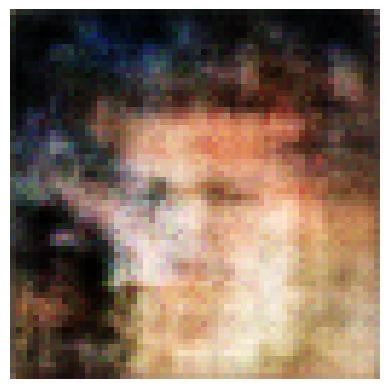

2/2 [==============================] - 5s 3s/step - c_loss: -13.1376 - c_wass_loss: -15.4490 - c_gp: 0.2311 - g_loss: -33.1768
Epoch 100/200
2/2 [==============================] - ETA: 0s - c_loss: -11.6291 - c_wass_loss: -13.5068 - c_gp: 0.1878 - g_loss: -53.1664

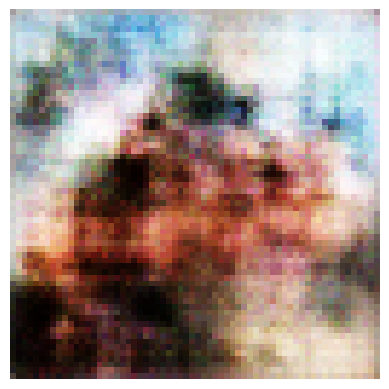

2/2 [==============================] - 5s 3s/step - c_loss: -11.6291 - c_wass_loss: -13.5068 - c_gp: 0.1878 - g_loss: -53.1664
Epoch 101/200
2/2 [==============================] - ETA: 0s - c_loss: -12.1037 - c_wass_loss: -14.0524 - c_gp: 0.1949 - g_loss: -48.1466

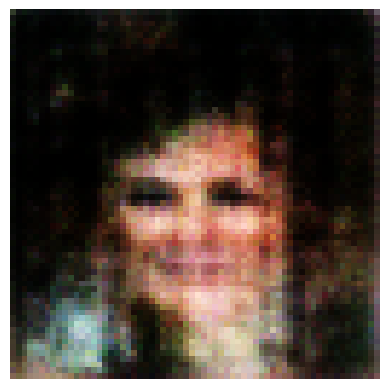

2/2 [==============================] - 5s 3s/step - c_loss: -12.1037 - c_wass_loss: -14.0524 - c_gp: 0.1949 - g_loss: -48.1466
Epoch 102/200
2/2 [==============================] - ETA: 0s - c_loss: -11.2733 - c_wass_loss: -13.0894 - c_gp: 0.1816 - g_loss: -59.5398

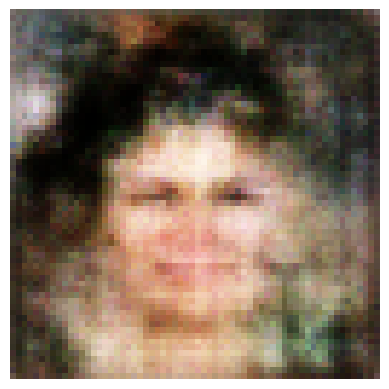

2/2 [==============================] - 5s 3s/step - c_loss: -11.2733 - c_wass_loss: -13.0894 - c_gp: 0.1816 - g_loss: -59.5398
Epoch 103/200
2/2 [==============================] - ETA: 0s - c_loss: -11.5525 - c_wass_loss: -13.3843 - c_gp: 0.1832 - g_loss: -66.9071

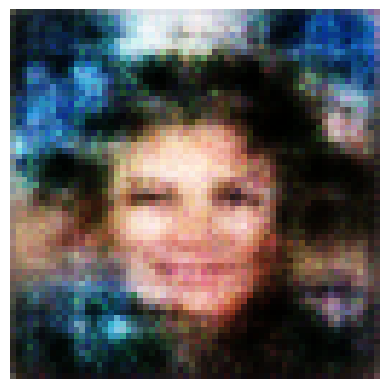

2/2 [==============================] - 5s 3s/step - c_loss: -11.5525 - c_wass_loss: -13.3843 - c_gp: 0.1832 - g_loss: -66.9071
Epoch 104/200
2/2 [==============================] - ETA: 0s - c_loss: -12.2435 - c_wass_loss: -14.4671 - c_gp: 0.2224 - g_loss: -52.7450

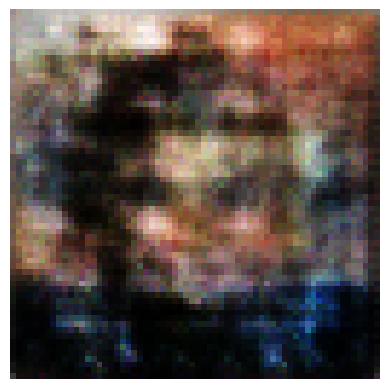

2/2 [==============================] - 5s 3s/step - c_loss: -12.2435 - c_wass_loss: -14.4671 - c_gp: 0.2224 - g_loss: -52.7450
Epoch 105/200
2/2 [==============================] - ETA: 0s - c_loss: -12.8159 - c_wass_loss: -14.9880 - c_gp: 0.2172 - g_loss: -45.3156

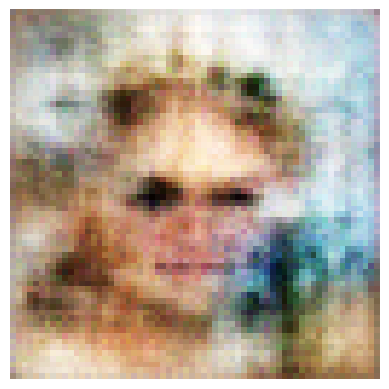

2/2 [==============================] - 5s 3s/step - c_loss: -12.8159 - c_wass_loss: -14.9880 - c_gp: 0.2172 - g_loss: -45.3156
Epoch 106/200
2/2 [==============================] - ETA: 0s - c_loss: -10.9618 - c_wass_loss: -12.9455 - c_gp: 0.1984 - g_loss: -60.8451

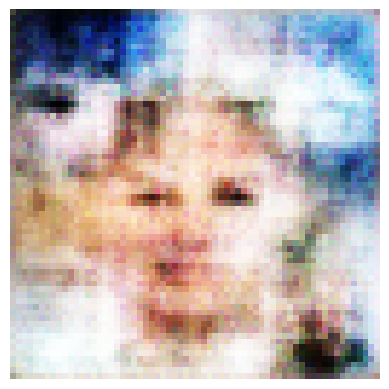

2/2 [==============================] - 5s 3s/step - c_loss: -10.9618 - c_wass_loss: -12.9455 - c_gp: 0.1984 - g_loss: -60.8451
Epoch 107/200
2/2 [==============================] - ETA: 0s - c_loss: -11.1836 - c_wass_loss: -12.8733 - c_gp: 0.1690 - g_loss: -63.6398

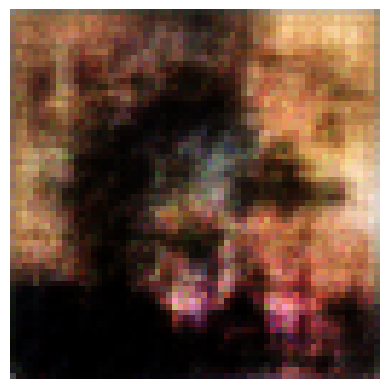

2/2 [==============================] - 5s 3s/step - c_loss: -11.1836 - c_wass_loss: -12.8733 - c_gp: 0.1690 - g_loss: -63.6398
Epoch 108/200
2/2 [==============================] - ETA: 0s - c_loss: -11.8825 - c_wass_loss: -14.1870 - c_gp: 0.2305 - g_loss: -62.9242

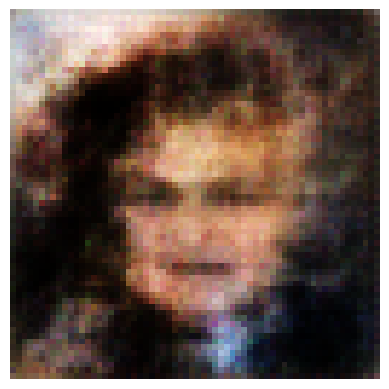

2/2 [==============================] - 5s 3s/step - c_loss: -11.8825 - c_wass_loss: -14.1870 - c_gp: 0.2305 - g_loss: -62.9242
Epoch 109/200
2/2 [==============================] - ETA: 0s - c_loss: -11.3590 - c_wass_loss: -13.3550 - c_gp: 0.1996 - g_loss: -51.2352

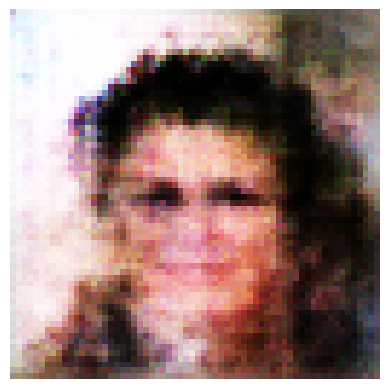

2/2 [==============================] - 5s 3s/step - c_loss: -11.3590 - c_wass_loss: -13.3550 - c_gp: 0.1996 - g_loss: -51.2352
Epoch 110/200
2/2 [==============================] - ETA: 0s - c_loss: -12.0146 - c_wass_loss: -14.0372 - c_gp: 0.2023 - g_loss: -60.9947

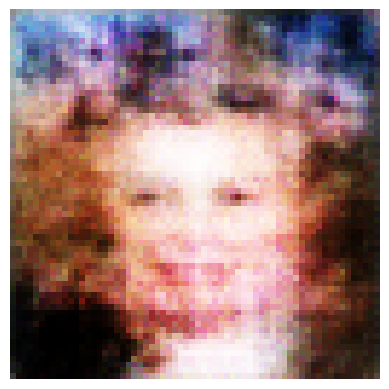

2/2 [==============================] - 5s 3s/step - c_loss: -12.0146 - c_wass_loss: -14.0372 - c_gp: 0.2023 - g_loss: -60.9947
Epoch 111/200
2/2 [==============================] - ETA: 0s - c_loss: -11.1652 - c_wass_loss: -12.8766 - c_gp: 0.1711 - g_loss: -65.4844

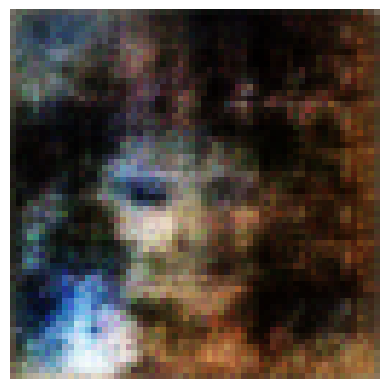

2/2 [==============================] - 5s 3s/step - c_loss: -11.1652 - c_wass_loss: -12.8766 - c_gp: 0.1711 - g_loss: -65.4844
Epoch 112/200
2/2 [==============================] - ETA: 0s - c_loss: -10.9553 - c_wass_loss: -12.5952 - c_gp: 0.1640 - g_loss: -53.5088

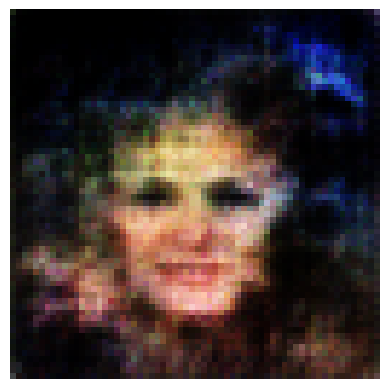

2/2 [==============================] - 5s 3s/step - c_loss: -10.9553 - c_wass_loss: -12.5952 - c_gp: 0.1640 - g_loss: -53.5088
Epoch 113/200
2/2 [==============================] - ETA: 0s - c_loss: -11.1366 - c_wass_loss: -12.6709 - c_gp: 0.1534 - g_loss: -52.1461

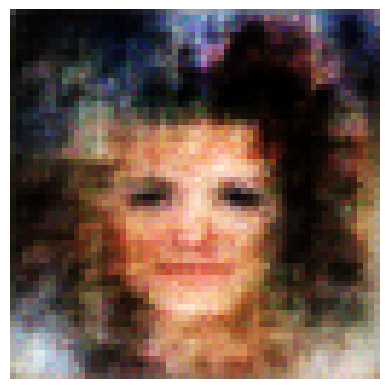

2/2 [==============================] - 5s 3s/step - c_loss: -11.1366 - c_wass_loss: -12.6709 - c_gp: 0.1534 - g_loss: -52.1461
Epoch 114/200
2/2 [==============================] - ETA: 0s - c_loss: -11.0771 - c_wass_loss: -12.8693 - c_gp: 0.1792 - g_loss: -55.8979

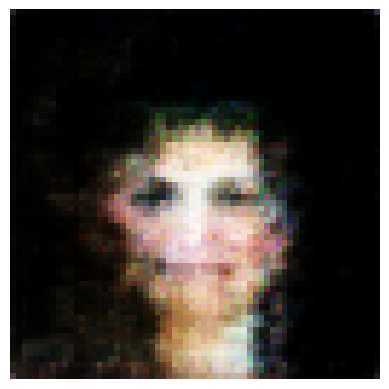

2/2 [==============================] - 5s 3s/step - c_loss: -11.0771 - c_wass_loss: -12.8693 - c_gp: 0.1792 - g_loss: -55.8979
Epoch 115/200
2/2 [==============================] - ETA: 0s - c_loss: -10.8478 - c_wass_loss: -12.6492 - c_gp: 0.1801 - g_loss: -55.5350

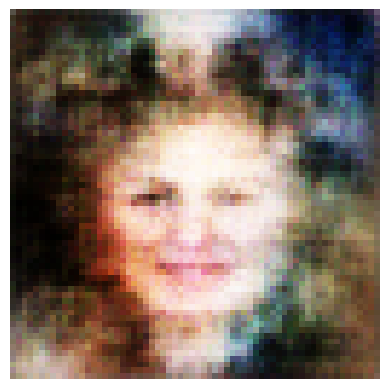

2/2 [==============================] - 5s 3s/step - c_loss: -10.8478 - c_wass_loss: -12.6492 - c_gp: 0.1801 - g_loss: -55.5350
Epoch 116/200
2/2 [==============================] - ETA: 0s - c_loss: -10.6819 - c_wass_loss: -12.6434 - c_gp: 0.1962 - g_loss: -70.3780

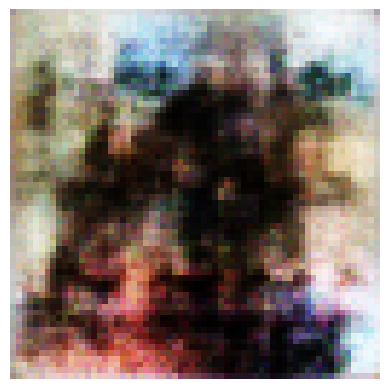

2/2 [==============================] - 5s 3s/step - c_loss: -10.6819 - c_wass_loss: -12.6434 - c_gp: 0.1962 - g_loss: -70.3780
Epoch 117/200
2/2 [==============================] - ETA: 0s - c_loss: -10.3325 - c_wass_loss: -11.9176 - c_gp: 0.1585 - g_loss: -63.4799

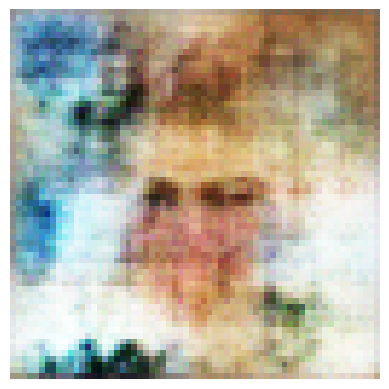

2/2 [==============================] - 5s 3s/step - c_loss: -10.3325 - c_wass_loss: -11.9176 - c_gp: 0.1585 - g_loss: -63.4799
Epoch 118/200
2/2 [==============================] - ETA: 0s - c_loss: -9.7702 - c_wass_loss: -11.0514 - c_gp: 0.1281 - g_loss: -58.4254

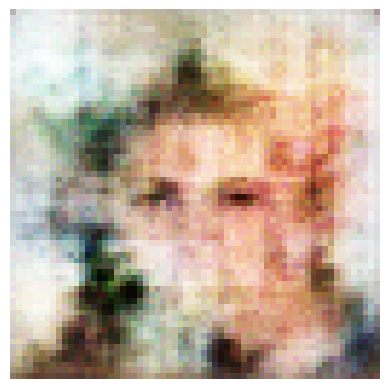

2/2 [==============================] - 5s 3s/step - c_loss: -9.7702 - c_wass_loss: -11.0514 - c_gp: 0.1281 - g_loss: -58.4254
Epoch 119/200
2/2 [==============================] - ETA: 0s - c_loss: -10.0139 - c_wass_loss: -11.2196 - c_gp: 0.1206 - g_loss: -54.7390

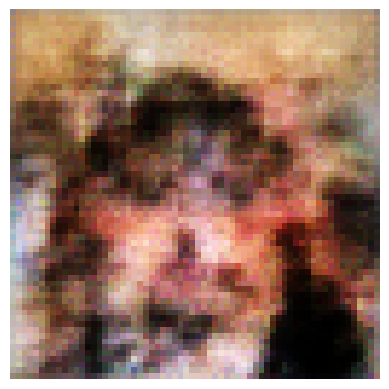

2/2 [==============================] - 5s 3s/step - c_loss: -10.0139 - c_wass_loss: -11.2196 - c_gp: 0.1206 - g_loss: -54.7390
Epoch 120/200
2/2 [==============================] - ETA: 0s - c_loss: -10.6469 - c_wass_loss: -12.2636 - c_gp: 0.1617 - g_loss: -54.7274

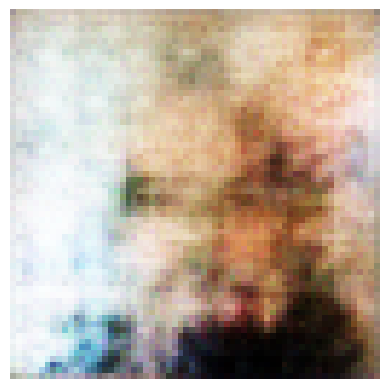

2/2 [==============================] - 5s 3s/step - c_loss: -10.6469 - c_wass_loss: -12.2636 - c_gp: 0.1617 - g_loss: -54.7274
Epoch 121/200
2/2 [==============================] - ETA: 0s - c_loss: -10.0333 - c_wass_loss: -11.6780 - c_gp: 0.1645 - g_loss: -60.9922

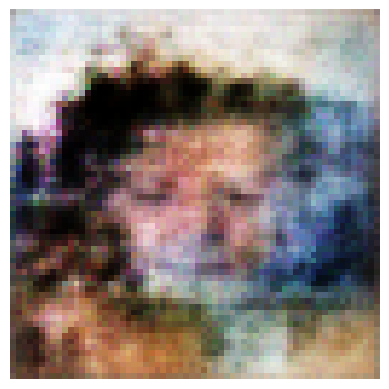

2/2 [==============================] - 5s 3s/step - c_loss: -10.0333 - c_wass_loss: -11.6780 - c_gp: 0.1645 - g_loss: -60.9922
Epoch 122/200
2/2 [==============================] - ETA: 0s - c_loss: -9.9152 - c_wass_loss: -11.4672 - c_gp: 0.1552 - g_loss: -62.3949 

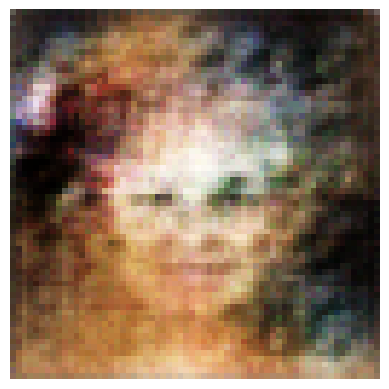

2/2 [==============================] - 5s 3s/step - c_loss: -9.9152 - c_wass_loss: -11.4672 - c_gp: 0.1552 - g_loss: -62.3949
Epoch 123/200
2/2 [==============================] - ETA: 0s - c_loss: -10.4403 - c_wass_loss: -11.7232 - c_gp: 0.1283 - g_loss: -63.7902

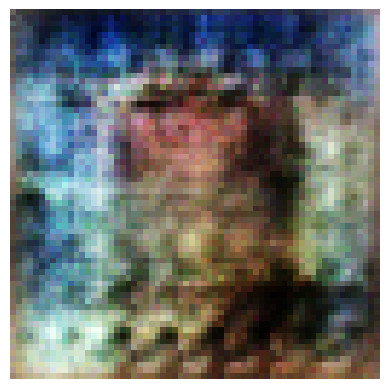

2/2 [==============================] - 5s 3s/step - c_loss: -10.4403 - c_wass_loss: -11.7232 - c_gp: 0.1283 - g_loss: -63.7902
Epoch 124/200
2/2 [==============================] - ETA: 0s - c_loss: -9.8059 - c_wass_loss: -11.1163 - c_gp: 0.1310 - g_loss: -60.2878

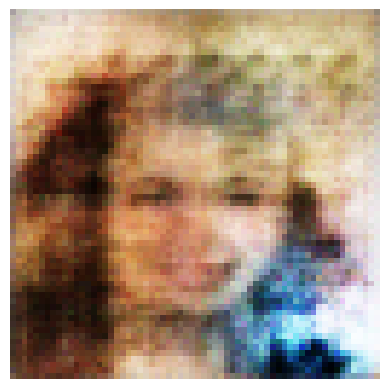

2/2 [==============================] - 5s 3s/step - c_loss: -9.8059 - c_wass_loss: -11.1163 - c_gp: 0.1310 - g_loss: -60.2878
Epoch 125/200
2/2 [==============================] - ETA: 0s - c_loss: -10.9795 - c_wass_loss: -12.6576 - c_gp: 0.1678 - g_loss: -60.5367

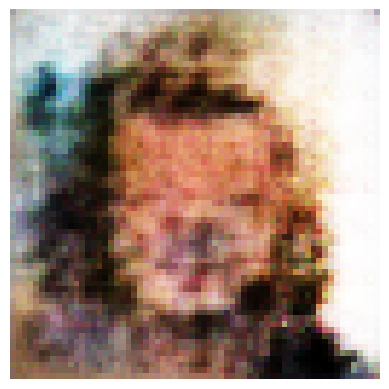

2/2 [==============================] - 5s 3s/step - c_loss: -10.9795 - c_wass_loss: -12.6576 - c_gp: 0.1678 - g_loss: -60.5367
Epoch 126/200
2/2 [==============================] - ETA: 0s - c_loss: -11.2522 - c_wass_loss: -12.8848 - c_gp: 0.1633 - g_loss: -45.0246

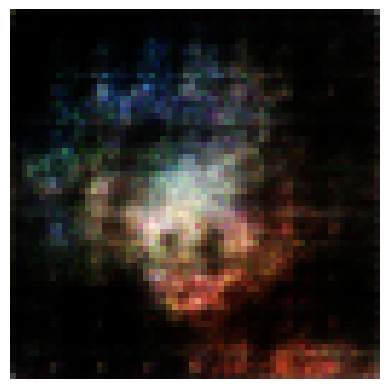

2/2 [==============================] - 5s 3s/step - c_loss: -11.2522 - c_wass_loss: -12.8848 - c_gp: 0.1633 - g_loss: -45.0246
Epoch 127/200
2/2 [==============================] - ETA: 0s - c_loss: -10.9328 - c_wass_loss: -12.6160 - c_gp: 0.1683 - g_loss: -55.0873

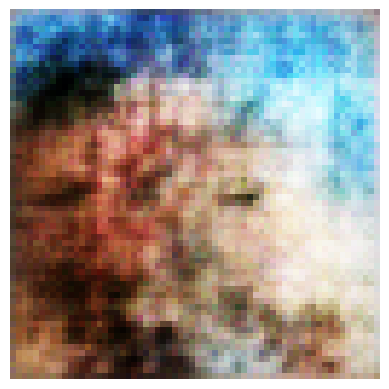

2/2 [==============================] - 5s 3s/step - c_loss: -10.9328 - c_wass_loss: -12.6160 - c_gp: 0.1683 - g_loss: -55.0873
Epoch 128/200
2/2 [==============================] - ETA: 0s - c_loss: -9.9438 - c_wass_loss: -11.4290 - c_gp: 0.1485 - g_loss: -71.6264 

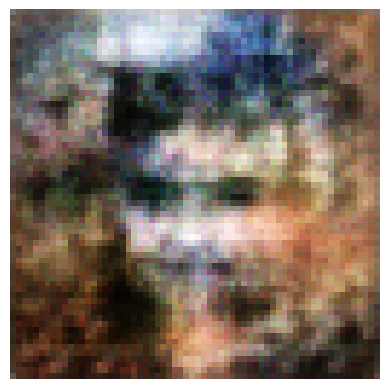

2/2 [==============================] - 5s 3s/step - c_loss: -9.9438 - c_wass_loss: -11.4290 - c_gp: 0.1485 - g_loss: -71.6264
Epoch 129/200
2/2 [==============================] - ETA: 0s - c_loss: -11.3884 - c_wass_loss: -13.1489 - c_gp: 0.1761 - g_loss: -68.2541

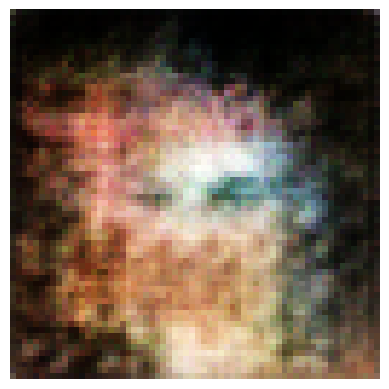

2/2 [==============================] - 5s 3s/step - c_loss: -11.3884 - c_wass_loss: -13.1489 - c_gp: 0.1761 - g_loss: -68.2541
Epoch 130/200
2/2 [==============================] - ETA: 0s - c_loss: -10.7261 - c_wass_loss: -12.5627 - c_gp: 0.1837 - g_loss: -59.5647

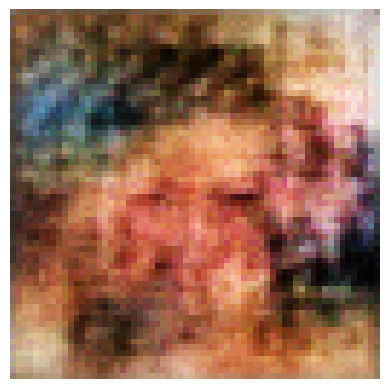

2/2 [==============================] - 5s 3s/step - c_loss: -10.7261 - c_wass_loss: -12.5627 - c_gp: 0.1837 - g_loss: -59.5647
Epoch 131/200
2/2 [==============================] - ETA: 0s - c_loss: -11.3552 - c_wass_loss: -13.2462 - c_gp: 0.1891 - g_loss: -70.5720

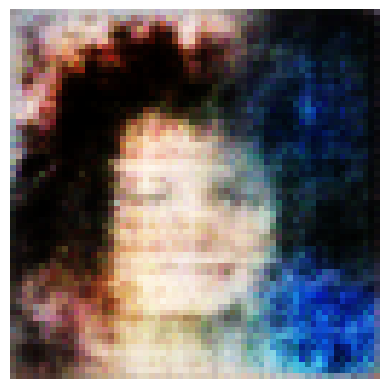

2/2 [==============================] - 5s 3s/step - c_loss: -11.3552 - c_wass_loss: -13.2462 - c_gp: 0.1891 - g_loss: -70.5720
Epoch 132/200
2/2 [==============================] - ETA: 0s - c_loss: -10.7230 - c_wass_loss: -12.2774 - c_gp: 0.1554 - g_loss: -54.0040

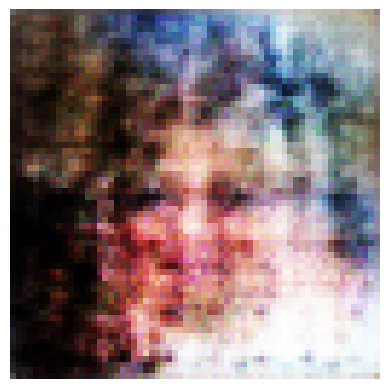

2/2 [==============================] - 5s 3s/step - c_loss: -10.7230 - c_wass_loss: -12.2774 - c_gp: 0.1554 - g_loss: -54.0040
Epoch 133/200
2/2 [==============================] - ETA: 0s - c_loss: -10.3480 - c_wass_loss: -11.8987 - c_gp: 0.1551 - g_loss: -59.8879

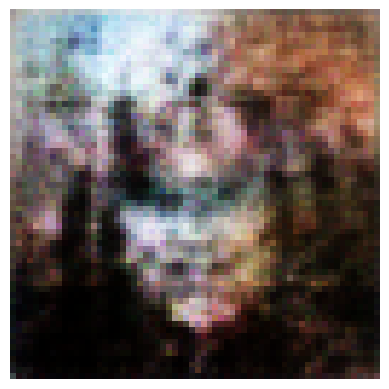

2/2 [==============================] - 5s 3s/step - c_loss: -10.3480 - c_wass_loss: -11.8987 - c_gp: 0.1551 - g_loss: -59.8879
Epoch 134/200
2/2 [==============================] - ETA: 0s - c_loss: -10.6737 - c_wass_loss: -12.0140 - c_gp: 0.1340 - g_loss: -67.3409

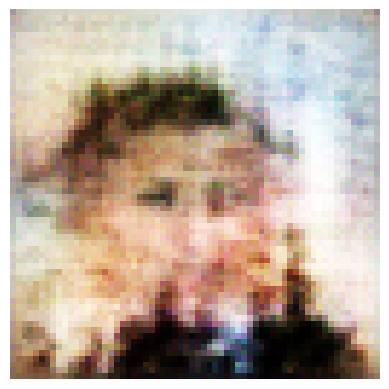

2/2 [==============================] - 5s 3s/step - c_loss: -10.6737 - c_wass_loss: -12.0140 - c_gp: 0.1340 - g_loss: -67.3409
Epoch 135/200
2/2 [==============================] - ETA: 0s - c_loss: -10.7477 - c_wass_loss: -12.5664 - c_gp: 0.1819 - g_loss: -56.2981

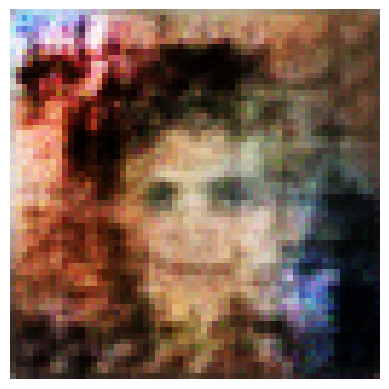

2/2 [==============================] - 5s 3s/step - c_loss: -10.7477 - c_wass_loss: -12.5664 - c_gp: 0.1819 - g_loss: -56.2981
Epoch 136/200
2/2 [==============================] - ETA: 0s - c_loss: -9.8266 - c_wass_loss: -11.2548 - c_gp: 0.1428 - g_loss: -50.1635

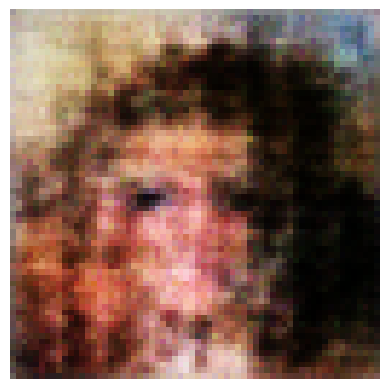

2/2 [==============================] - 5s 3s/step - c_loss: -9.8266 - c_wass_loss: -11.2548 - c_gp: 0.1428 - g_loss: -50.1635
Epoch 137/200
2/2 [==============================] - ETA: 0s - c_loss: -10.0914 - c_wass_loss: -11.6874 - c_gp: 0.1596 - g_loss: -60.1121

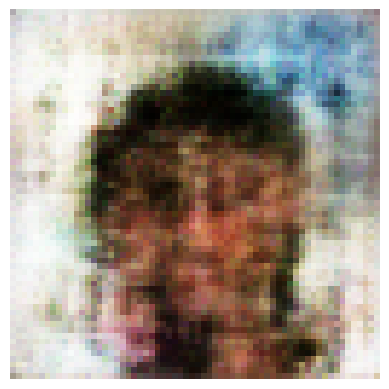

2/2 [==============================] - 5s 3s/step - c_loss: -10.0914 - c_wass_loss: -11.6874 - c_gp: 0.1596 - g_loss: -60.1121
Epoch 138/200
2/2 [==============================] - ETA: 0s - c_loss: -10.7879 - c_wass_loss: -12.2078 - c_gp: 0.1420 - g_loss: -56.0375

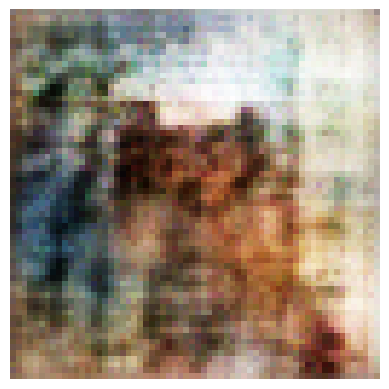

2/2 [==============================] - 5s 3s/step - c_loss: -10.7879 - c_wass_loss: -12.2078 - c_gp: 0.1420 - g_loss: -56.0375
Epoch 139/200
2/2 [==============================] - ETA: 0s - c_loss: -11.2213 - c_wass_loss: -12.9858 - c_gp: 0.1765 - g_loss: -51.4883

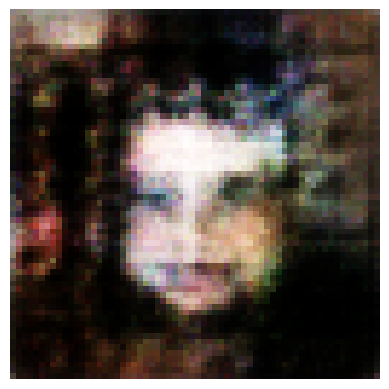

2/2 [==============================] - 5s 3s/step - c_loss: -11.2213 - c_wass_loss: -12.9858 - c_gp: 0.1765 - g_loss: -51.4883
Epoch 140/200
2/2 [==============================] - ETA: 0s - c_loss: -11.2109 - c_wass_loss: -13.0197 - c_gp: 0.1809 - g_loss: -63.0149

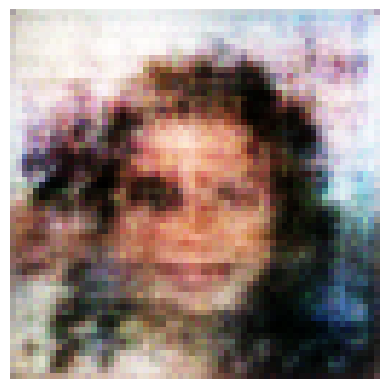

2/2 [==============================] - 5s 3s/step - c_loss: -11.2109 - c_wass_loss: -13.0197 - c_gp: 0.1809 - g_loss: -63.0149
Epoch 141/200
2/2 [==============================] - ETA: 0s - c_loss: -10.2955 - c_wass_loss: -11.8371 - c_gp: 0.1542 - g_loss: -60.8092

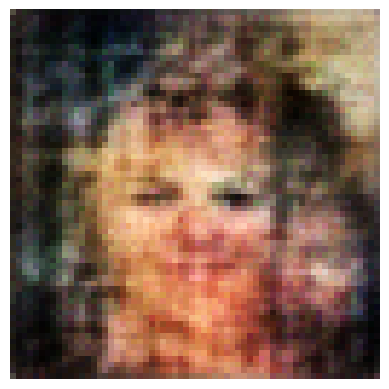

2/2 [==============================] - 5s 3s/step - c_loss: -10.2955 - c_wass_loss: -11.8371 - c_gp: 0.1542 - g_loss: -60.8092
Epoch 142/200
2/2 [==============================] - ETA: 0s - c_loss: -10.1541 - c_wass_loss: -11.9575 - c_gp: 0.1803 - g_loss: -61.5893

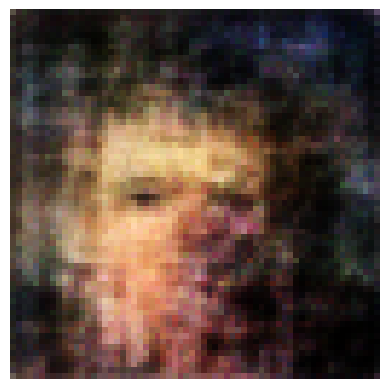

2/2 [==============================] - 5s 3s/step - c_loss: -10.1541 - c_wass_loss: -11.9575 - c_gp: 0.1803 - g_loss: -61.5893
Epoch 143/200
2/2 [==============================] - ETA: 0s - c_loss: -10.9277 - c_wass_loss: -12.4851 - c_gp: 0.1557 - g_loss: -66.1478

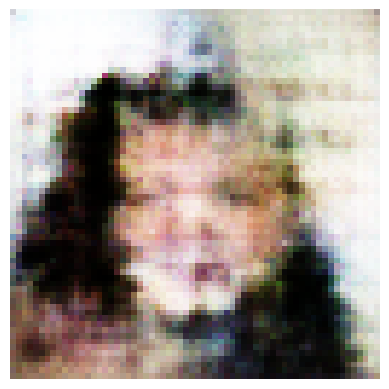

2/2 [==============================] - 5s 3s/step - c_loss: -10.9277 - c_wass_loss: -12.4851 - c_gp: 0.1557 - g_loss: -66.1478
Epoch 144/200
2/2 [==============================] - ETA: 0s - c_loss: -11.5519 - c_wass_loss: -13.6229 - c_gp: 0.2071 - g_loss: -63.6610

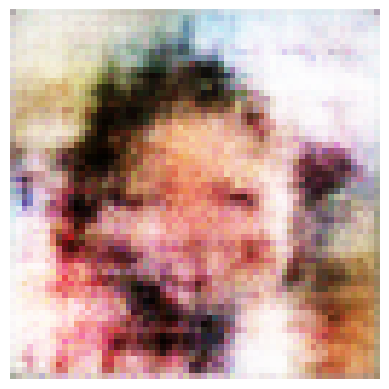

2/2 [==============================] - 5s 3s/step - c_loss: -11.5519 - c_wass_loss: -13.6229 - c_gp: 0.2071 - g_loss: -63.6610
Epoch 145/200
2/2 [==============================] - ETA: 0s - c_loss: -10.2949 - c_wass_loss: -12.0260 - c_gp: 0.1731 - g_loss: -51.9068

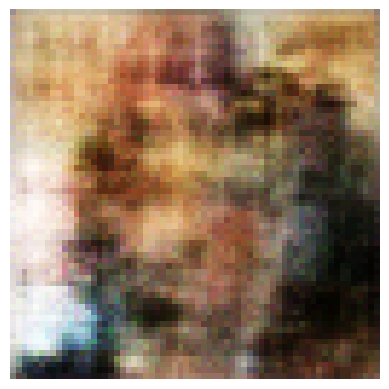

2/2 [==============================] - 5s 3s/step - c_loss: -10.2949 - c_wass_loss: -12.0260 - c_gp: 0.1731 - g_loss: -51.9068
Epoch 146/200
2/2 [==============================] - ETA: 0s - c_loss: -10.3462 - c_wass_loss: -12.0238 - c_gp: 0.1678 - g_loss: -48.2259

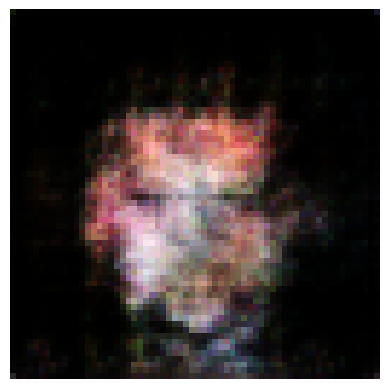

2/2 [==============================] - 5s 3s/step - c_loss: -10.3462 - c_wass_loss: -12.0238 - c_gp: 0.1678 - g_loss: -48.2259
Epoch 147/200
2/2 [==============================] - ETA: 0s - c_loss: -10.4070 - c_wass_loss: -11.7815 - c_gp: 0.1374 - g_loss: -58.5406

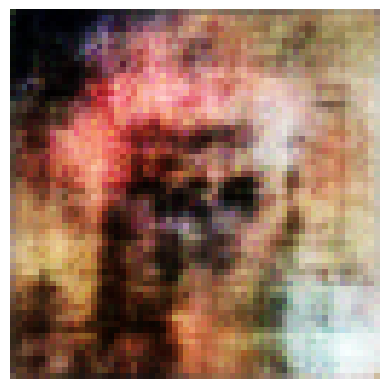

2/2 [==============================] - 5s 3s/step - c_loss: -10.4070 - c_wass_loss: -11.7815 - c_gp: 0.1374 - g_loss: -58.5406
Epoch 148/200
2/2 [==============================] - ETA: 0s - c_loss: -9.7624 - c_wass_loss: -11.3788 - c_gp: 0.1616 - g_loss: -67.4707 

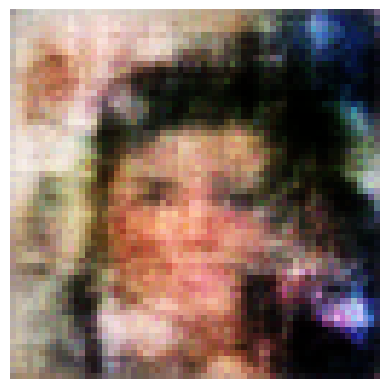

2/2 [==============================] - 5s 3s/step - c_loss: -9.7624 - c_wass_loss: -11.3788 - c_gp: 0.1616 - g_loss: -67.4707
Epoch 149/200
2/2 [==============================] - ETA: 0s - c_loss: -9.7289 - c_wass_loss: -10.9953 - c_gp: 0.1266 - g_loss: -60.1976

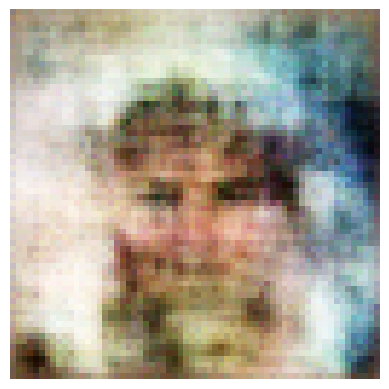

2/2 [==============================] - 5s 3s/step - c_loss: -9.7289 - c_wass_loss: -10.9953 - c_gp: 0.1266 - g_loss: -60.1976
Epoch 150/200
2/2 [==============================] - ETA: 0s - c_loss: -9.8350 - c_wass_loss: -11.4222 - c_gp: 0.1587 - g_loss: -56.3257

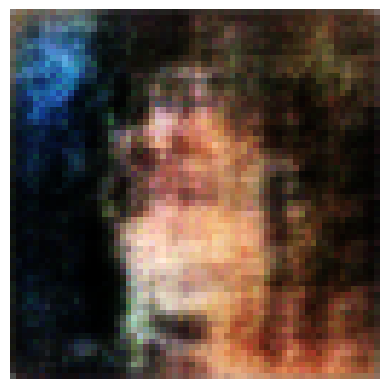

2/2 [==============================] - 5s 3s/step - c_loss: -9.8350 - c_wass_loss: -11.4222 - c_gp: 0.1587 - g_loss: -56.3257
Epoch 151/200
2/2 [==============================] - ETA: 0s - c_loss: -9.0123 - c_wass_loss: -10.5411 - c_gp: 0.1529 - g_loss: -58.1055

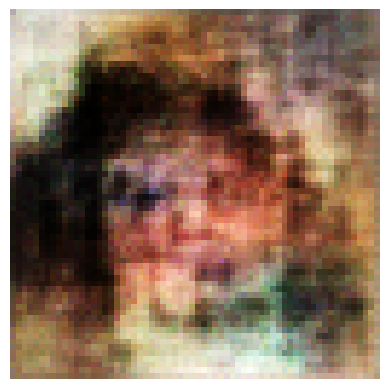

2/2 [==============================] - 5s 3s/step - c_loss: -9.0123 - c_wass_loss: -10.5411 - c_gp: 0.1529 - g_loss: -58.1055
Epoch 152/200
2/2 [==============================] - ETA: 0s - c_loss: -10.9045 - c_wass_loss: -12.3650 - c_gp: 0.1461 - g_loss: -63.8370

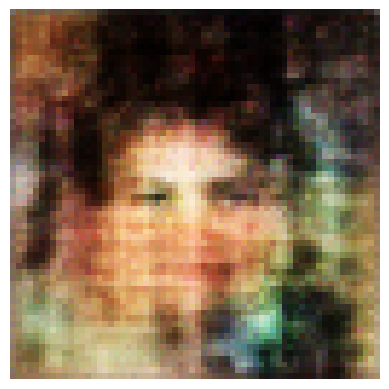

2/2 [==============================] - 5s 3s/step - c_loss: -10.9045 - c_wass_loss: -12.3650 - c_gp: 0.1461 - g_loss: -63.8370
Epoch 153/200
2/2 [==============================] - ETA: 0s - c_loss: -8.9602 - c_wass_loss: -10.4130 - c_gp: 0.1453 - g_loss: -62.1107

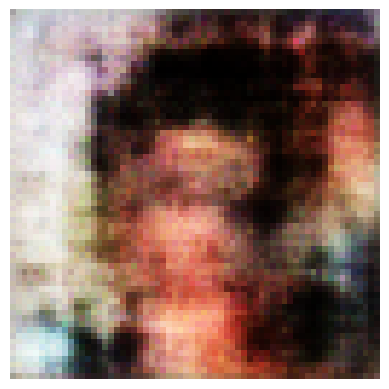

2/2 [==============================] - 5s 3s/step - c_loss: -8.9602 - c_wass_loss: -10.4130 - c_gp: 0.1453 - g_loss: -62.1107
Epoch 154/200
2/2 [==============================] - ETA: 0s - c_loss: -9.1003 - c_wass_loss: -10.2351 - c_gp: 0.1135 - g_loss: -55.0146

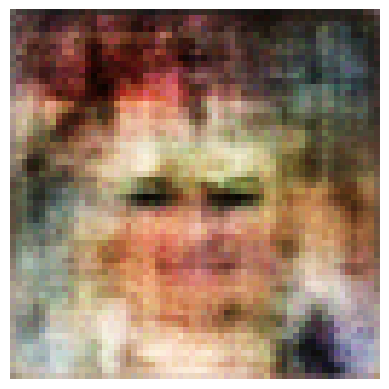

2/2 [==============================] - 5s 3s/step - c_loss: -9.1003 - c_wass_loss: -10.2351 - c_gp: 0.1135 - g_loss: -55.0146
Epoch 155/200
2/2 [==============================] - ETA: 0s - c_loss: -9.9899 - c_wass_loss: -11.3214 - c_gp: 0.1332 - g_loss: -54.3770

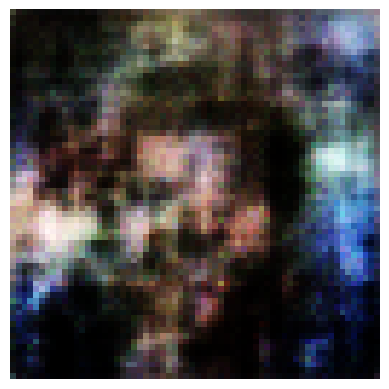

2/2 [==============================] - 5s 3s/step - c_loss: -9.9899 - c_wass_loss: -11.3214 - c_gp: 0.1332 - g_loss: -54.3770
Epoch 156/200
2/2 [==============================] - ETA: 0s - c_loss: -10.3117 - c_wass_loss: -11.8901 - c_gp: 0.1578 - g_loss: -53.3801

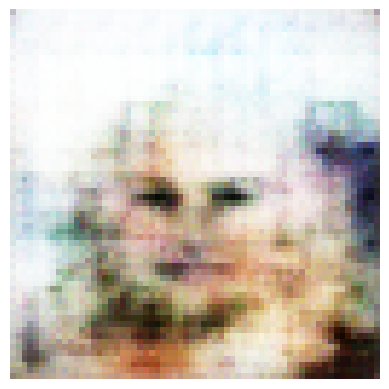

2/2 [==============================] - 5s 3s/step - c_loss: -10.3117 - c_wass_loss: -11.8901 - c_gp: 0.1578 - g_loss: -53.3801
Epoch 157/200
2/2 [==============================] - ETA: 0s - c_loss: -9.7128 - c_wass_loss: -11.4251 - c_gp: 0.1712 - g_loss: -64.3145

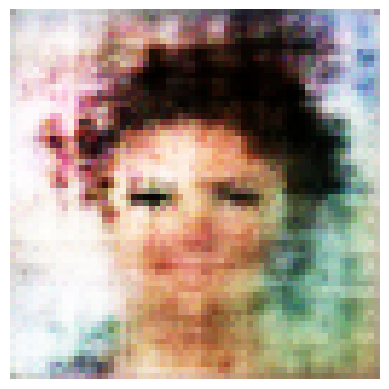

2/2 [==============================] - 5s 3s/step - c_loss: -9.7128 - c_wass_loss: -11.4251 - c_gp: 0.1712 - g_loss: -64.3145
Epoch 158/200
2/2 [==============================] - ETA: 0s - c_loss: -9.6020 - c_wass_loss: -10.9978 - c_gp: 0.1396 - g_loss: -60.9848

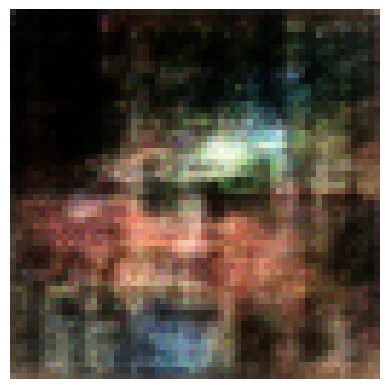

2/2 [==============================] - 5s 3s/step - c_loss: -9.6020 - c_wass_loss: -10.9978 - c_gp: 0.1396 - g_loss: -60.9848
Epoch 159/200
2/2 [==============================] - ETA: 0s - c_loss: -9.9309 - c_wass_loss: -11.4378 - c_gp: 0.1507 - g_loss: -61.1336

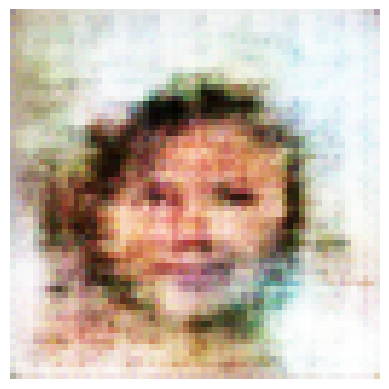

2/2 [==============================] - 5s 3s/step - c_loss: -9.9309 - c_wass_loss: -11.4378 - c_gp: 0.1507 - g_loss: -61.1336
Epoch 160/200
2/2 [==============================] - ETA: 0s - c_loss: -9.9490 - c_wass_loss: -11.4429 - c_gp: 0.1494 - g_loss: -69.2843 

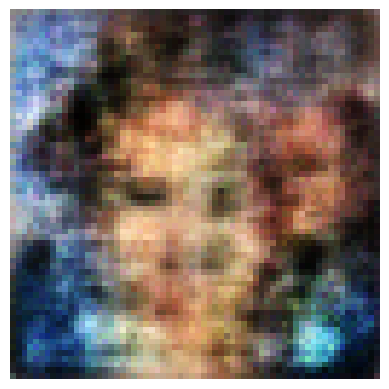

2/2 [==============================] - 5s 3s/step - c_loss: -9.9490 - c_wass_loss: -11.4429 - c_gp: 0.1494 - g_loss: -69.2843
Epoch 161/200
2/2 [==============================] - ETA: 0s - c_loss: -9.3474 - c_wass_loss: -10.7712 - c_gp: 0.1424 - g_loss: -53.0414

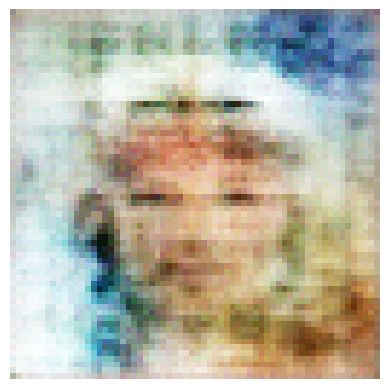

2/2 [==============================] - 5s 3s/step - c_loss: -9.3474 - c_wass_loss: -10.7712 - c_gp: 0.1424 - g_loss: -53.0414
Epoch 162/200
2/2 [==============================] - ETA: 0s - c_loss: -9.4673 - c_wass_loss: -10.8821 - c_gp: 0.1415 - g_loss: -68.6605

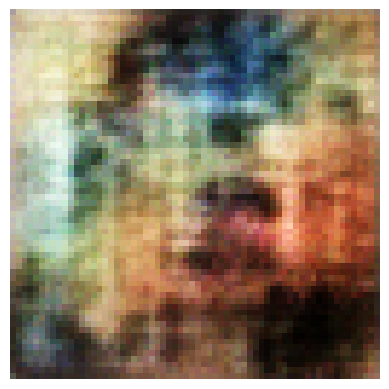

2/2 [==============================] - 5s 3s/step - c_loss: -9.4673 - c_wass_loss: -10.8821 - c_gp: 0.1415 - g_loss: -68.6605
Epoch 163/200
2/2 [==============================] - ETA: 0s - c_loss: -9.1086 - c_wass_loss: -10.4530 - c_gp: 0.1344 - g_loss: -61.7171

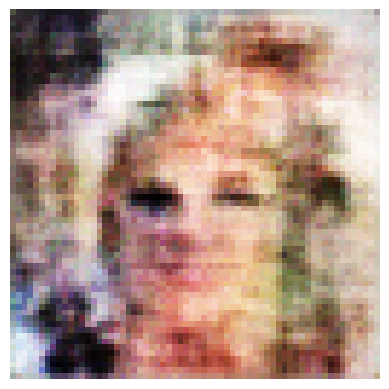

2/2 [==============================] - 5s 3s/step - c_loss: -9.1086 - c_wass_loss: -10.4530 - c_gp: 0.1344 - g_loss: -61.7171
Epoch 164/200
2/2 [==============================] - ETA: 0s - c_loss: -10.0607 - c_wass_loss: -11.6513 - c_gp: 0.1591 - g_loss: -54.2989

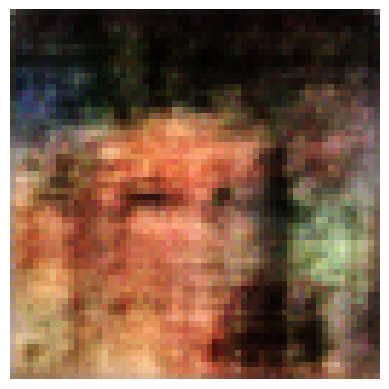

2/2 [==============================] - 5s 3s/step - c_loss: -10.0607 - c_wass_loss: -11.6513 - c_gp: 0.1591 - g_loss: -54.2989
Epoch 165/200
2/2 [==============================] - ETA: 0s - c_loss: -9.2026 - c_wass_loss: -10.8404 - c_gp: 0.1638 - g_loss: -66.8858

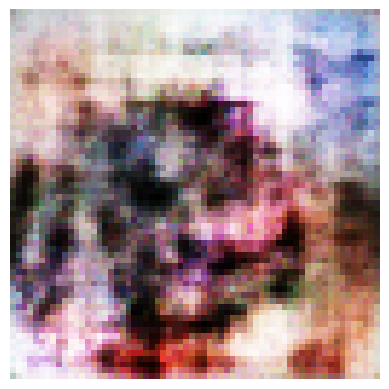

2/2 [==============================] - 5s 3s/step - c_loss: -9.2026 - c_wass_loss: -10.8404 - c_gp: 0.1638 - g_loss: -66.8858
Epoch 166/200
2/2 [==============================] - ETA: 0s - c_loss: -8.7754 - c_wass_loss: -10.0605 - c_gp: 0.1285 - g_loss: -77.0806

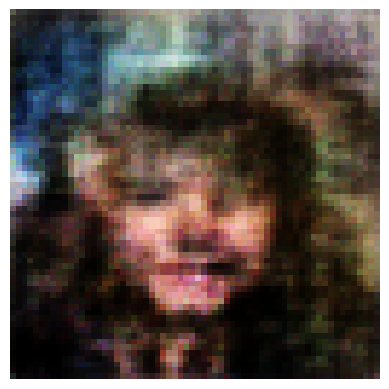

2/2 [==============================] - 5s 3s/step - c_loss: -8.7754 - c_wass_loss: -10.0605 - c_gp: 0.1285 - g_loss: -77.0806
Epoch 167/200
2/2 [==============================] - ETA: 0s - c_loss: -9.2874 - c_wass_loss: -10.6125 - c_gp: 0.1325 - g_loss: -65.5521

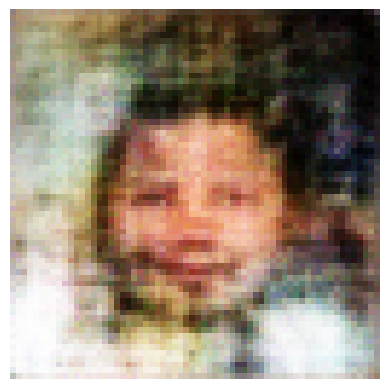

2/2 [==============================] - 5s 3s/step - c_loss: -9.2874 - c_wass_loss: -10.6125 - c_gp: 0.1325 - g_loss: -65.5521
Epoch 168/200
2/2 [==============================] - ETA: 0s - c_loss: -11.3358 - c_wass_loss: -13.0458 - c_gp: 0.1710 - g_loss: -51.0711

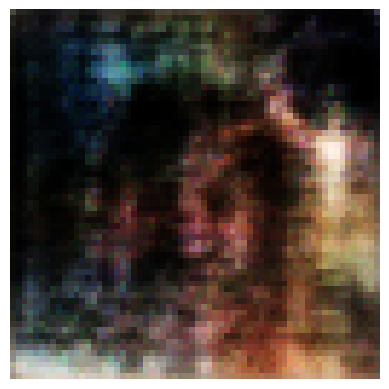

2/2 [==============================] - 5s 3s/step - c_loss: -11.3358 - c_wass_loss: -13.0458 - c_gp: 0.1710 - g_loss: -51.0711
Epoch 169/200
2/2 [==============================] - ETA: 0s - c_loss: -9.4480 - c_wass_loss: -10.8517 - c_gp: 0.1404 - g_loss: -64.7439

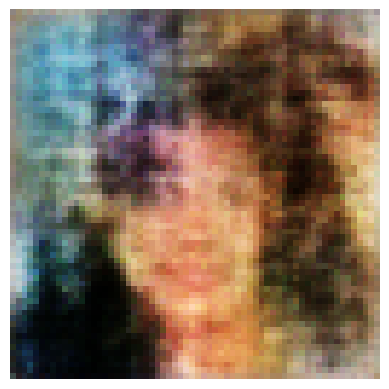

2/2 [==============================] - 5s 3s/step - c_loss: -9.4480 - c_wass_loss: -10.8517 - c_gp: 0.1404 - g_loss: -64.7439
Epoch 170/200
2/2 [==============================] - ETA: 0s - c_loss: -9.3783 - c_wass_loss: -10.8680 - c_gp: 0.1490 - g_loss: -73.2922

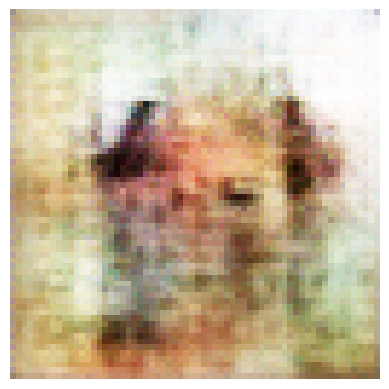

2/2 [==============================] - 5s 3s/step - c_loss: -9.3783 - c_wass_loss: -10.8680 - c_gp: 0.1490 - g_loss: -73.2922
Epoch 171/200
2/2 [==============================] - ETA: 0s - c_loss: -8.8769 - c_wass_loss: -10.0515 - c_gp: 0.1175 - g_loss: -71.8514

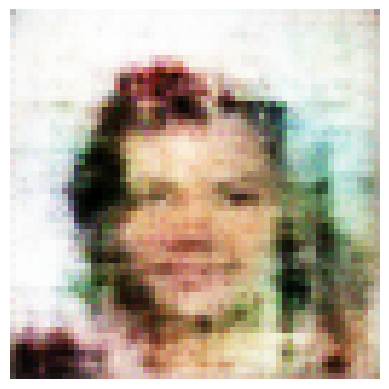

2/2 [==============================] - 5s 3s/step - c_loss: -8.8769 - c_wass_loss: -10.0515 - c_gp: 0.1175 - g_loss: -71.8514
Epoch 172/200
2/2 [==============================] - ETA: 0s - c_loss: -9.5348 - c_wass_loss: -10.7124 - c_gp: 0.1178 - g_loss: -59.4314

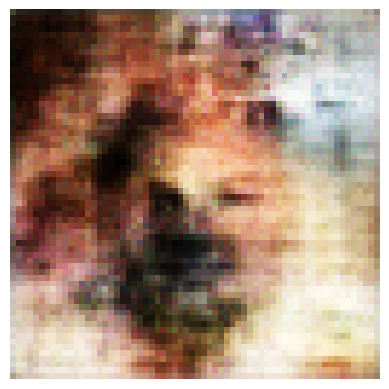

2/2 [==============================] - 5s 3s/step - c_loss: -9.5348 - c_wass_loss: -10.7124 - c_gp: 0.1178 - g_loss: -59.4314
Epoch 173/200
2/2 [==============================] - ETA: 0s - c_loss: -9.8057 - c_wass_loss: -11.3653 - c_gp: 0.1560 - g_loss: -56.6304 

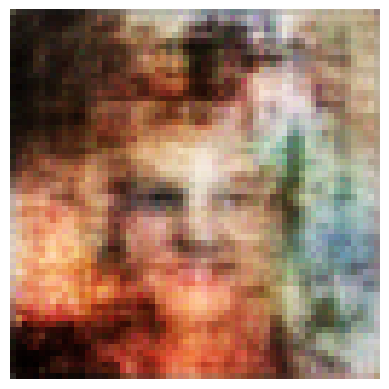

2/2 [==============================] - 5s 3s/step - c_loss: -9.8057 - c_wass_loss: -11.3653 - c_gp: 0.1560 - g_loss: -56.6304
Epoch 174/200
2/2 [==============================] - ETA: 0s - c_loss: -9.7291 - c_wass_loss: -11.2240 - c_gp: 0.1495 - g_loss: -54.7426 

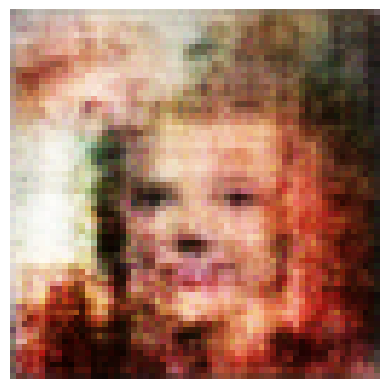

2/2 [==============================] - 5s 3s/step - c_loss: -9.7291 - c_wass_loss: -11.2240 - c_gp: 0.1495 - g_loss: -54.7426
Epoch 175/200
2/2 [==============================] - ETA: 0s - c_loss: -10.4142 - c_wass_loss: -12.3184 - c_gp: 0.1904 - g_loss: -62.7011

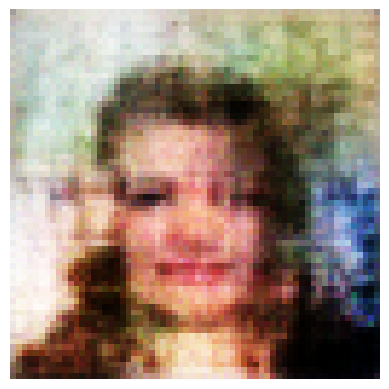

2/2 [==============================] - 5s 3s/step - c_loss: -10.4142 - c_wass_loss: -12.3184 - c_gp: 0.1904 - g_loss: -62.7011
Epoch 176/200
2/2 [==============================] - ETA: 0s - c_loss: -9.4381 - c_wass_loss: -10.6343 - c_gp: 0.1196 - g_loss: -72.5618

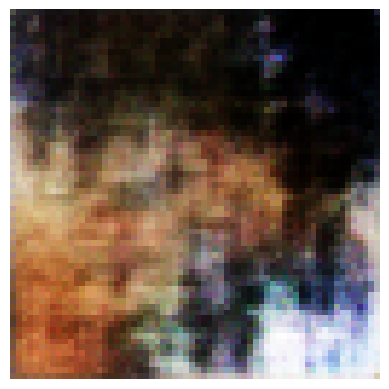

2/2 [==============================] - 5s 3s/step - c_loss: -9.4381 - c_wass_loss: -10.6343 - c_gp: 0.1196 - g_loss: -72.5618
Epoch 177/200
2/2 [==============================] - ETA: 0s - c_loss: -9.4215 - c_wass_loss: -10.8941 - c_gp: 0.1473 - g_loss: -74.7886

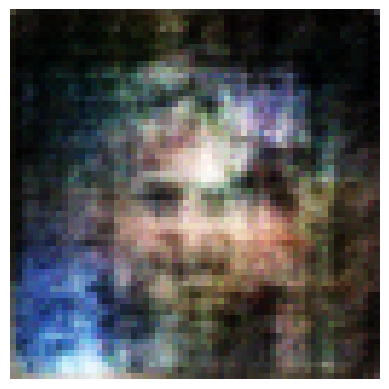

2/2 [==============================] - 5s 3s/step - c_loss: -9.4215 - c_wass_loss: -10.8941 - c_gp: 0.1473 - g_loss: -74.7886
Epoch 178/200
2/2 [==============================] - ETA: 0s - c_loss: -9.2290 - c_wass_loss: -10.4186 - c_gp: 0.1190 - g_loss: -60.7448

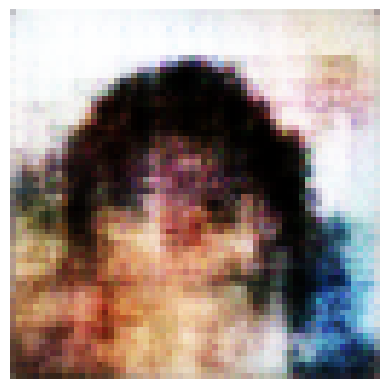

2/2 [==============================] - 5s 3s/step - c_loss: -9.2290 - c_wass_loss: -10.4186 - c_gp: 0.1190 - g_loss: -60.7448
Epoch 179/200
2/2 [==============================] - ETA: 0s - c_loss: -9.6589 - c_wass_loss: -11.1661 - c_gp: 0.1507 - g_loss: -61.8402

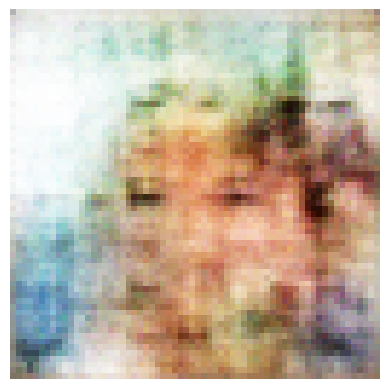

2/2 [==============================] - 5s 3s/step - c_loss: -9.6589 - c_wass_loss: -11.1661 - c_gp: 0.1507 - g_loss: -61.8402
Epoch 180/200
2/2 [==============================] - ETA: 0s - c_loss: -9.0035 - c_wass_loss: -10.1137 - c_gp: 0.1110 - g_loss: -65.4365

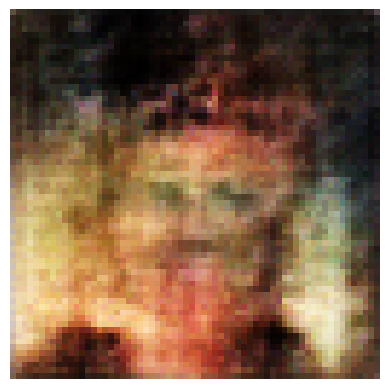

2/2 [==============================] - 5s 3s/step - c_loss: -9.0035 - c_wass_loss: -10.1137 - c_gp: 0.1110 - g_loss: -65.4365
Epoch 181/200
2/2 [==============================] - ETA: 0s - c_loss: -9.0655 - c_wass_loss: -10.6283 - c_gp: 0.1563 - g_loss: -66.4316

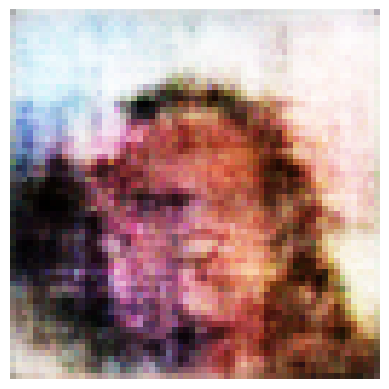

2/2 [==============================] - 5s 3s/step - c_loss: -9.0655 - c_wass_loss: -10.6283 - c_gp: 0.1563 - g_loss: -66.4316
Epoch 182/200
2/2 [==============================] - ETA: 0s - c_loss: -9.0946 - c_wass_loss: -10.2931 - c_gp: 0.1198 - g_loss: -60.3694

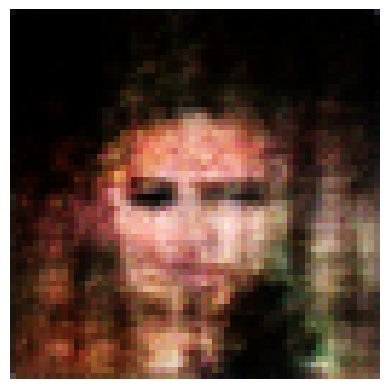

2/2 [==============================] - 5s 3s/step - c_loss: -9.0946 - c_wass_loss: -10.2931 - c_gp: 0.1198 - g_loss: -60.3694
Epoch 183/200
2/2 [==============================] - ETA: 0s - c_loss: -9.1112 - c_wass_loss: -10.4733 - c_gp: 0.1362 - g_loss: -61.4577

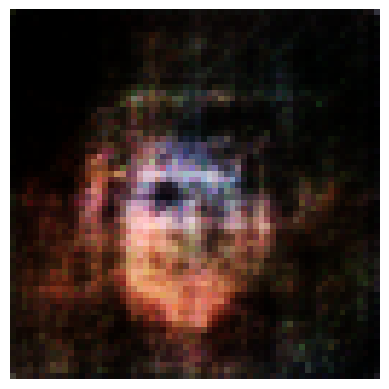

2/2 [==============================] - 5s 3s/step - c_loss: -9.1112 - c_wass_loss: -10.4733 - c_gp: 0.1362 - g_loss: -61.4577
Epoch 184/200
2/2 [==============================] - ETA: 0s - c_loss: -9.4513 - c_wass_loss: -10.5800 - c_gp: 0.1129 - g_loss: -73.4055

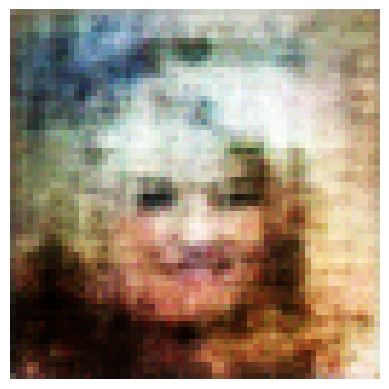

2/2 [==============================] - 5s 3s/step - c_loss: -9.4513 - c_wass_loss: -10.5800 - c_gp: 0.1129 - g_loss: -73.4055
Epoch 185/200
2/2 [==============================] - ETA: 0s - c_loss: -9.5518 - c_wass_loss: -10.7941 - c_gp: 0.1242 - g_loss: -72.8737 

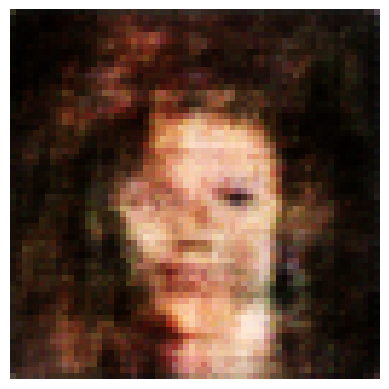

2/2 [==============================] - 5s 3s/step - c_loss: -9.5518 - c_wass_loss: -10.7941 - c_gp: 0.1242 - g_loss: -72.8737
Epoch 186/200
2/2 [==============================] - ETA: 0s - c_loss: -8.8973 - c_wass_loss: -10.1410 - c_gp: 0.1244 - g_loss: -68.5136

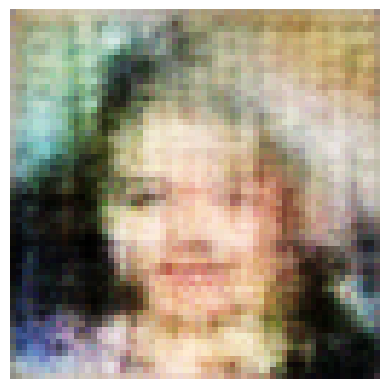

2/2 [==============================] - 5s 3s/step - c_loss: -8.8973 - c_wass_loss: -10.1410 - c_gp: 0.1244 - g_loss: -68.5136
Epoch 187/200
2/2 [==============================] - ETA: 0s - c_loss: -9.7178 - c_wass_loss: -11.0389 - c_gp: 0.1321 - g_loss: -65.8791

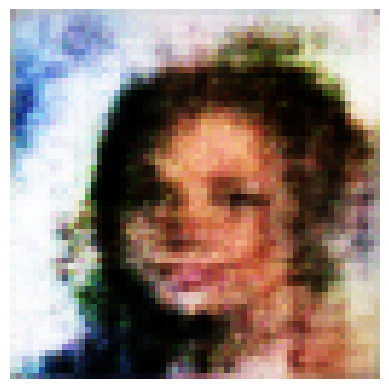

2/2 [==============================] - 5s 3s/step - c_loss: -9.7178 - c_wass_loss: -11.0389 - c_gp: 0.1321 - g_loss: -65.8791
Epoch 188/200
2/2 [==============================] - ETA: 0s - c_loss: -9.4117 - c_wass_loss: -10.8646 - c_gp: 0.1453 - g_loss: -62.9793

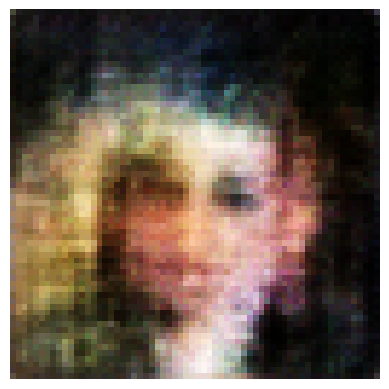

2/2 [==============================] - 5s 3s/step - c_loss: -9.4117 - c_wass_loss: -10.8646 - c_gp: 0.1453 - g_loss: -62.9793
Epoch 189/200
2/2 [==============================] - ETA: 0s - c_loss: -8.9251 - c_wass_loss: -10.4170 - c_gp: 0.1492 - g_loss: -60.7883

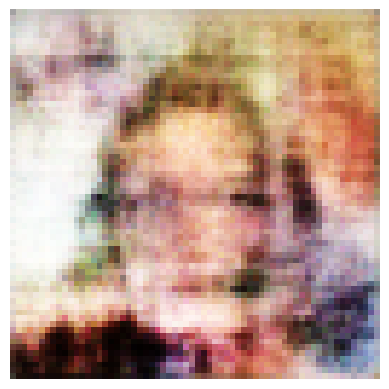

2/2 [==============================] - 5s 3s/step - c_loss: -8.9251 - c_wass_loss: -10.4170 - c_gp: 0.1492 - g_loss: -60.7883
Epoch 190/200
2/2 [==============================] - ETA: 0s - c_loss: -9.2678 - c_wass_loss: -10.4040 - c_gp: 0.1136 - g_loss: -67.5250

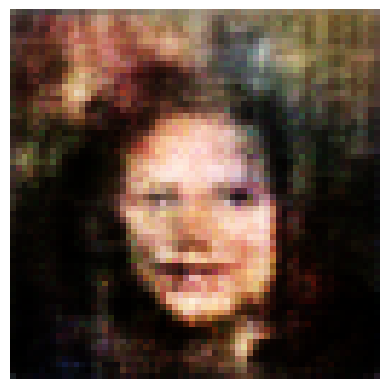

2/2 [==============================] - 5s 3s/step - c_loss: -9.2678 - c_wass_loss: -10.4040 - c_gp: 0.1136 - g_loss: -67.5250
Epoch 191/200
2/2 [==============================] - ETA: 0s - c_loss: -8.6703 - c_wass_loss: -9.7827 - c_gp: 0.1112 - g_loss: -78.9503

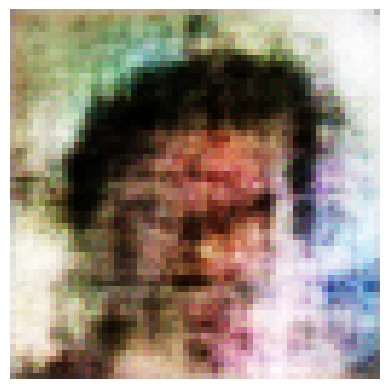

2/2 [==============================] - 5s 3s/step - c_loss: -8.6703 - c_wass_loss: -9.7827 - c_gp: 0.1112 - g_loss: -78.9503
Epoch 192/200
2/2 [==============================] - ETA: 0s - c_loss: -9.9162 - c_wass_loss: -11.3295 - c_gp: 0.1413 - g_loss: -68.6670

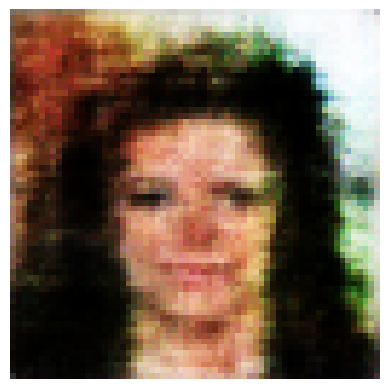

2/2 [==============================] - 5s 3s/step - c_loss: -9.9162 - c_wass_loss: -11.3295 - c_gp: 0.1413 - g_loss: -68.6670
Epoch 193/200
2/2 [==============================] - ETA: 0s - c_loss: -9.9590 - c_wass_loss: -11.6192 - c_gp: 0.1660 - g_loss: -63.1875 

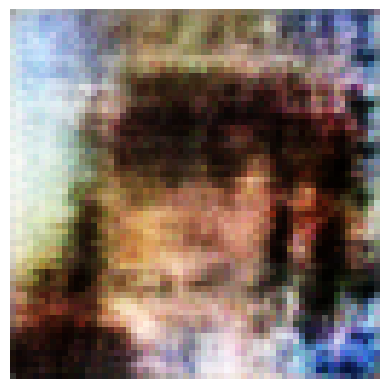

2/2 [==============================] - 5s 3s/step - c_loss: -9.9590 - c_wass_loss: -11.6192 - c_gp: 0.1660 - g_loss: -63.1875
Epoch 194/200
2/2 [==============================] - ETA: 0s - c_loss: -9.2155 - c_wass_loss: -10.5125 - c_gp: 0.1297 - g_loss: -55.5770

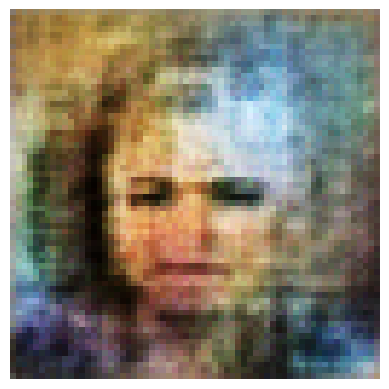

2/2 [==============================] - 5s 3s/step - c_loss: -9.2155 - c_wass_loss: -10.5125 - c_gp: 0.1297 - g_loss: -55.5770
Epoch 195/200
2/2 [==============================] - ETA: 0s - c_loss: -8.7462 - c_wass_loss: -9.8564 - c_gp: 0.1110 - g_loss: -71.2631

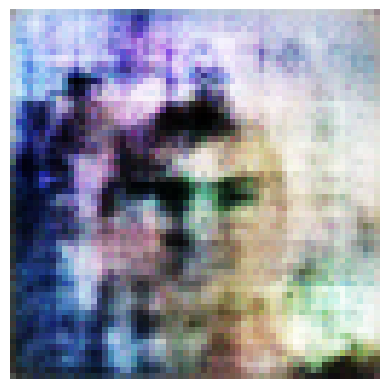

2/2 [==============================] - 5s 3s/step - c_loss: -8.7462 - c_wass_loss: -9.8564 - c_gp: 0.1110 - g_loss: -71.2631
Epoch 196/200
2/2 [==============================] - ETA: 0s - c_loss: -9.1004 - c_wass_loss: -10.4652 - c_gp: 0.1365 - g_loss: -77.8937

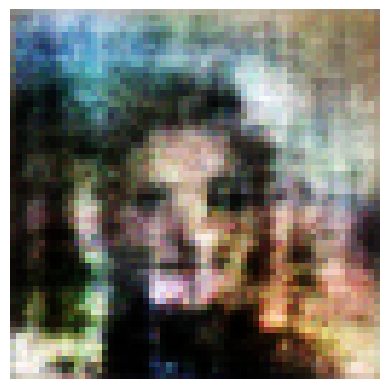

2/2 [==============================] - 5s 3s/step - c_loss: -9.1004 - c_wass_loss: -10.4652 - c_gp: 0.1365 - g_loss: -77.8937
Epoch 197/200
2/2 [==============================] - ETA: 0s - c_loss: -7.8916 - c_wass_loss: -9.0873 - c_gp: 0.1196 - g_loss: -74.2832

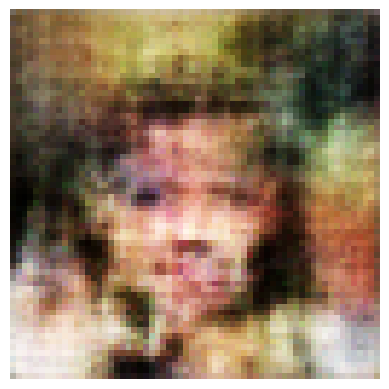

2/2 [==============================] - 5s 3s/step - c_loss: -7.8916 - c_wass_loss: -9.0873 - c_gp: 0.1196 - g_loss: -74.2832
Epoch 198/200
2/2 [==============================] - ETA: 0s - c_loss: -8.8475 - c_wass_loss: -10.0923 - c_gp: 0.1245 - g_loss: -65.3663

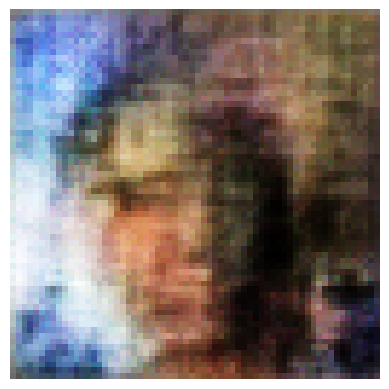

2/2 [==============================] - 10s 7s/step - c_loss: -8.8475 - c_wass_loss: -10.0923 - c_gp: 0.1245 - g_loss: -65.3663
Epoch 199/200


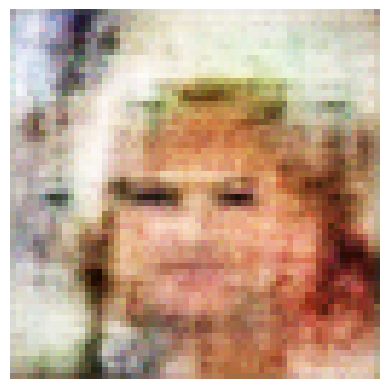

2/2 [==============================] - 1s 372ms/step - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - c_gp: 0.0000e+00 - g_loss: 0.0000e+00


In [16]:
wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=2,
    callbacks=[
        model_checkpoint_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

We have now covered all of the key differences between a standard GAN and a
WGAN-GP. To recap:

• A WGAN-GP uses the Wasserstein loss.

• The WGAN-GP is trained using labels of 1 for real and –1 for fake.

• There is no sigmoid activation in the final layer of the critic.

• Include a gradient penalty term in the loss function for the critic.

• Train the critic multiple times for each update of the generator.

• There are no batch normalization layers in the critic.

In [18]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)

1/1 [==============================] - 0s 32ms/step


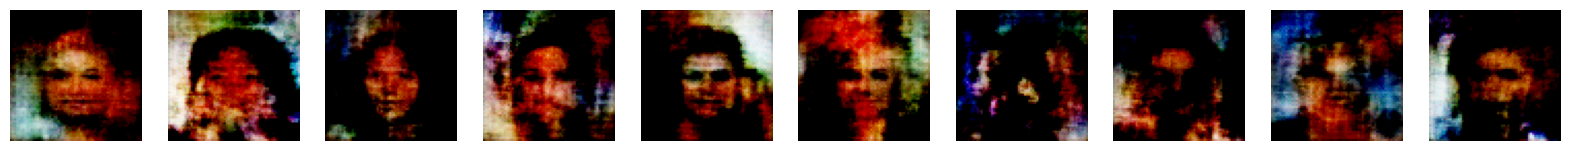

In [19]:
# Display the images using matplotlib
fig, axs = plt.subplots(1, 10, figsize=(20, 2))  # Adjust figsize accordingly
for i in range(10):
    axs[i].imshow(imgs[i])
    axs[i].axis('off')

plt.show()

Looks Like more training is required and hyperparameter finetuning